In [1]:
from lemaitre import georges
georges.setup_logger(level='INFO')
from lemaitre import bandpasses

filterlib = bandpasses.get_filterlib()

2025-04-22 18:37:21 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /cfs/home/angi0819/.cache/bbf/lemaitre_flib.default.e6bf3ada09e4924f0f2b01c0619d97de11296ba5a7c236c66b125d5d3b11041b.pkl


In [88]:
import os
nthreads=12
os.environ['OMP_NUM_THREADS'] = str(nthreads)
os.environ['MKL_NUM_THREADS'] = str(nthreads)
os.environ['OPENBLAS_NUM_THREADS'] = str(nthreads)
os.environ['NUMEXPR_NUM_THREADS'] = str(nthreads)


In [2]:
import skysurvey
import numpy as np
import sncosmo
import pandas
from src import *
from tqdm.auto import tqdm
import jax.numpy as jnp
import pickle

2025-04-22 18:37:23 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /cfs/home/angi0819/.cache/bbf/lemaitre_flib.default.e6bf3ada09e4924f0f2b01c0619d97de11296ba5a7c236c66b125d5d3b11041b.pkl
2025-04-22 18:37:25 INFO arviz.preview - arviz_base not installed
2025-04-22 18:37:25 INFO arviz.preview - arviz_stats not installed
2025-04-22 18:37:25 INFO arviz.preview - arviz_plots not installed
INFO:2025-04-22 18:37:25,704:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-04-22 18:37:25 INFO jax._src.xla_bridge - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-22 18:37:25,709:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-04-22 18:37:25 INFO jax._src.xla_bridge - Unable to initialize backend 'tpu': INTER

In [3]:
import warnings
from iminuit.warnings import IMinuitWarning

warnings.filterwarnings("ignore", category=IMinuitWarning)

In [4]:
%matplotlib inline

In [5]:
survey_colors = dict(ZTF="tab:blue", SNLS="tab:orange", HSC="tab:green")

## 2M++ halos loading

When drawing from the 2M++ grid, enforce z_max=0.11677 otherwise it's not isotrope 

In [6]:
z_max = 0.11677295
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(name="2m++", H0=68.1, Om0=0.306)

In [7]:
import h5py

##### First loading

In [ ]:
import h5py

In [ ]:
with h5py.File("./data/hbt_subhalos_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(list(file["Subhalos"]))
    cosmo_params = {
        params: np.array(file["Cosmology"][params])[0]
        for params in list(file["Cosmology"])
    }
    positions = np.array(file["Subhalos"]["ComovingAveragePosition"])
    positions_mostbound = np.array(file["Subhalos"]["ComovingMostBoundPosition"])
    masses = np.array(file["Subhalos"]["BoundM200Crit"])
    velocities = np.array(file["Subhalos"]["PhysicalAverageVelocity"])
    ids = np.array(file["Subhalos"]["HostHaloId"])
    rmax = np.array(file["Subhalos"]["RmaxComoving"])

In [ ]:
with h5py.File("./data/delta_dm_cic_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(file["Header"])
    delta = np.array(file["delta_dm"])

with h5py.File("./data/velocity_cic_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(file["Header"])
    vpec = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])

In [ ]:
v = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)

In [ ]:
halos = pandas.DataFrame(
    {
        "pos_x": positions.T[0] - 500,
        "pos_y": positions.T[1] - 500,
        "pos_z": positions.T[2] - 500,
        "vx": velocities.T[0],
        "vy": velocities.T[1],
        "vz": velocities.T[2],
        "M200c": masses,
        "halo_id": ids,
        "Rmax": rmax,
    }
)


halos["d_c"] = np.sqrt(halos.pos_x**2 + halos.pos_y**2 + halos.pos_z**2)

halos["vpec"] = (
    halos.pos_x * halos.vx + halos.pos_y * halos.vy + halos.pos_z * halos.vz
) / halos.d_c

In [ ]:
plt.hist(vpec.ravel(), bins=100, density=True, histtype="step")
_ = plt.hist(halos.vpec, bins=100, density=True, histtype="step")

In [ ]:
from scipy.interpolate import interp1d

dc_to_z = interp1d(
    cosmo.comoving_distance(np.linspace(1e-3, 0.5, 10000)),
    np.linspace(1e-3, 0.5, 10000),
)

In [ ]:
halos["z_cosmo"] = dc_to_z(halos.d_c)

In [ ]:
halos["z"] = (1 + halos.z_cosmo) * (1 + halos.vpec / c * 1e3) - 1

In [ ]:
from astropy.coordinates import SkyCoord
from astropy.units import Mpc

coords = SkyCoord(
    x=halos.pos_x,
    y=halos.pos_y,
    z=halos.pos_z,
    representation_type="cartesian",
    unit=Mpc,
)

In [ ]:
halos["ra"] = coords.icrs.spherical.lon.value
halos.ra -= (halos.ra > 180) * 360
halos["dec"] = coords.icrs.spherical.lat.value

In [ ]:
halos.to_csv("data/2M++_subhalo_1.csv")

##### Some plots

In [ ]:
halos = pandas.read_csv("data/2M++_subhalo_0.csv")
halos_ = pandas.read_csv("data/2M++_subhalo_1.csv")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))
ax.scatter(halos.pos_x, halos.pos_y, halos.pos_z, s=2, marker=".", alpha=0.1)
ax.scatter(halos_.pos_x, halos_.pos_y, halos_.pos_z, s=2, marker=".", alpha=0.1)

In [ ]:
one_axis = np.linspace(0, 1000, 256, endpoint=False)
y, x, z = np.meshgrid(one_axis, one_axis, one_axis)
centroids = np.c_[x.ravel(),y.ravel(),z.ravel()] + 1000/512

In [ ]:
from scipy.spatial import cKDTree
tree = cKDTree(centroids, boxsize=1000)

In [ ]:
dist, id = tree.query(np.c_[halos.pos_x, halos.pos_y, halos.pos_z] + 500)
dist_, id_ = tree.query(np.c_[halos_.pos_x, halos_.pos_y, halos_.pos_z] + 500)

In [ ]:
positions = (centroids - 500)

In [ ]:
with h5py.File("./data/velocity_cic_0.hdf5", "r") as file:
    vpec = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])
v = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)
with h5py.File("./data/velocity_cic_1.hdf5", "r") as file:
    vpec_ = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])
v_ = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)

In [ ]:
my_vpec = np.sum(positions[id]*v.reshape(-1, 3)[id], axis=1)/np.sqrt(np.sum(positions[id]**2, axis=1))
my_vpec_ = np.sum(positions[id_]*v_.reshape(-1, 3)[id_], axis=1)/np.sqrt(np.sum(positions[id_]**2, axis=1))

In [ ]:
calc_vpec=np.sum(np.multiply(v.reshape(-1, 3)[id], positions[id]), axis=1)/np.linalg.norm(positions[id], ord=2, axis=1)
calc_vpec_=np.sum(np.multiply(v_.reshape(-1, 3)[id_], positions[id_]), axis=1)/np.linalg.norm(positions[id_], ord=2, axis=1)

In [ ]:
halos['calc_vpec'] = calc_vpec
halos_['calc_vpec'] = calc_vpec_

In [ ]:
halos.columns

In [ ]:
fig = corner_(halos, var_names=["pos_x", "pos_y", "pos_z", "vx", "vy", "vz", "vpec", "calc_vpec"], return_fig=True)
corner_(halos_, var_names=["pos_x", "pos_y", "pos_z", "vx", "vy", "vz", "vpec", "calc_vpec"], fig=fig, color='r')
plt.tight_layout()

In [ ]:
plt.hist(vpec.ravel(), bins=100, density=True, histtype="step", label=r"$VP_{grid}$")
_ = plt.hist(calc_vpec, bins=100, density=True, histtype="step", label=r"$VP_{calc}$")
_ = plt.hist(halos.vpec, bins=100, density=True, histtype="step", label=r"$VP_{halos}$")
plt.legend()


In [ ]:
plt.hist(vpec_.ravel(), bins=100, density=True, histtype="step", label=r"$VP_{grid}$")
_ = plt.hist(calc_vpec_, bins=100, density=True, histtype="step", label=r"$VP_{calc}$")
_ = plt.hist(halos_.vpec, bins=100, density=True, histtype="step", label=r"$VP_{halos}$")
plt.legend()


In [ ]:
_ = plt.hist(calc_vpec - halos.vpec, bins=100, density=True, histtype="step", label=r"$VP_{calc} - VP_{halos}$")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))
ax.scatter(*positions[id].T, s=2, marker=".", alpha=0.1)
ax.scatter(halos.pos_x, halos.pos_y, halos.pos_z, s=2, marker=".", alpha=0.1)

In [ ]:
_=plt.hist(vpec.ravel()[id_] - halos_.vpec, bins=100)
mean, std = (vpec.ravel()[id_] - halos_.vpec).mean(), (vpec.ravel()[id_] - halos_.vpec).std()
plt.axvline(mean, color="r", label=rf'Mean ${mean:.3g}$')
plt.axvline(mean + std, color="r", linestyle=':', label=rf'std ${std:.3g}$')
plt.axvline(mean - std, color="r", linestyle=':')
plt.xlabel(r"$vp_{grid} - vp_{halo}$")
plt.legend()

In [ ]:
plt.scatter(halos.z_cosmo, halos.z, marker=".", s=0.1, alpha=0.1)
plt.scatter(halos_.z_cosmo, halos_.z, marker=".", s=0.1, alpha=0.1)

In [ ]:
z_max = 0.11
n_bins = 10
width = z_max / n_bins
bounds = np.linspace(0, z_max - width, n_bins)

in_bins = [(halos.z > d_min) & (halos.z < d_min + width) for d_min in bounds]
in_bins_ = [(halos_.z > d_min) & (halos_.z < d_min + width) for d_min in bounds]
plt.scatter(
    halos.z[halos.z < z_max],
    halos.vpec[halos.z < z_max],
    marker=".",
    alpha=0.01,
    label="Grid 0",
)

plt.scatter(
    halos_.z[halos_.z < z_max],
    halos_.vpec[halos_.z < z_max],
    marker=".",
    color="tab:red",
    alpha=0.01,
    label="Grid 1",
)

plt.errorbar(
    bounds + width / 2,
    [halos.vpec[filt].mean() for filt in in_bins],
    yerr=[halos.vpec[filt].std() for filt in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    alpha=1,
    capsize=2,
)

plt.errorbar(
    bounds + width / 2,
    [halos_.vpec[filt].mean() for filt in in_bins_],
    yerr=[halos_.vpec[filt].std() for filt in in_bins_],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    alpha=1,
    capsize=2,
)

plt.axhline(0, color="k", linestyle=":")
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'vpec')


In [ ]:
fig, ax = plt.subplots(figsize=(20, 7), subplot_kw=dict(projection="mollweide"))
ax.scatter(
    halos.ra[halos.z_cosmo < 0.1] * np.pi / 180,
    halos.dec[halos.z_cosmo < 0.1] * np.pi / 180,
    marker=".",
    s=2,
    alpha=0.2,
)
ax.scatter(
    halos_.ra[halos_.z_cosmo < 0.1] * np.pi / 180,
    halos_.dec[halos_.z_cosmo < 0.1] * np.pi / 180,
    marker=".",
    s=2,
    alpha=0.2,
)

## Test georges

### Georges input formatting

In [53]:
lc_georges = pandas.read_parquet("./data/lc_data_0.parquet")

In [54]:
sn_georges = pandas.read_parquet("./data/sn_data_0.parquet")

In [55]:
spec_georges = pandas.read_parquet("./data/spec_data_0.parquet")

In [89]:
data_ztf, lc_ztf = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl", survey='ZTF')
data_hsc, lc_hsc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl", survey='HSC')
data_snls, lc_snls = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_snls.pkl", survey='SNLS')

In [90]:
data = pandas.concat([data_ztf, data_snls, data_hsc])
lc = pandas.concat([lc_ztf, lc_snls, lc_hsc])


In [91]:
data.rename(columns={"t0":"tmax"}, inplace=True)
data.reset_index(drop=True, inplace=True)
data["IAU"]=np.NaN
data["valid"]=1
data["sig_int"]=0.


In [92]:
data[sn_georges.columns].to_parquet("/cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/sn_data_0.parquet")

In [93]:
lc.rename(columns=dict(time="mjd", zpsys="magsys"), inplace=True)

In [94]:
ids = lc.groupby(["sn", "band"]).flux.count()

In [95]:
ids = pandas.Series(data = np.arange(len(ids)), index= ids.index)

In [96]:
lc['lc'] = ids.loc[zip(lc.sn, lc.band)].values

In [97]:
lc[['mag_sky', 'seeing', 'exptime', 'ccd', 'amp',]] = np.NaN
lc['valid'] = 1
lc['errorsnake'] = 0.

In [98]:
lc['mjd_round'] = np.floor(lc.mjd)

In [99]:
lc.drop(columns=['fieldid', 'survey'], inplace=True)

##### rcid and ccd pos

In [112]:
sn_miss = lc[np.isnan(lc.rcid)].sn.unique()
missing_rcid = pandas.DataFrame(np.random.randint(1,37, len(sn_miss)), index = sn_miss)
lc.loc[sn_miss, 'rcid'] = missing_rcid.loc[lc.loc[sn_miss].sn].values
lc.rcid = lc.rcid.astype(int)
nb_rcid = lc.groupby(['sn', 'rcid']).rcid.nunique()


In [113]:
pos = pandas.DataFrame(np.random.randint(1,3001, (len(nb_rcid), 2)), index=nb_rcid.index, columns=['x', 'y'])

In [ ]:
lc["x"] = pos.loc[zip(lc.sn, lc.rcid), "x"].values
lc["y"] = pos.loc[zip(lc.sn, lc.rcid), "y"].values

In [ ]:
lc.rename(columns={"rcid":"sensor_id"}, inplace=True)

In [ ]:
lc.reset_index(drop=True, inplace=True)

In [111]:
lc.band.unique()

array(['ztf::g', 'ztf::r', 'ztf::i', 'megacam6::g', 'megacam6::i',
       'megacam6::i2', 'megacam6::r', 'megacam6::z', 'hsc::Y', 'hsc::i2',
       'hsc::g', 'hsc::r2', 'hsc::z'], dtype=object)

In [109]:
lc_georges.band.unique()

array(['hsc::g', 'hsc::Y', 'hsc::i2', 'hsc::r2', 'hsc::z', 'MEGACAM6::g',
       'MEGACAM6::i', 'MEGACAM6::r', 'MEGACAM6::z', 'MEGACAM6::i2',
       'ztf::r', 'ztf::g', 'ztf::i'], dtype=object)

In [ ]:
lc[lc_georges.columns].to_parquet("/cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/lc_data_0.parquet")

In [36]:
spec_ztf = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_2M++.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_ztf['survey'] = 'ZTF'
spec_hsc = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_hsc.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_hsc['survey'] = 'HSC'
spec_snls = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_snls.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_snls['survey'] = 'SNLS'
shift_sp_ztf, shift_sp_snls = spec_ztf.spec.max()+1, spec_snls.spec.max()+1
spec_snls.spec += shift_sp_ztf
spec_hsc.spec += shift_sp_ztf + shift_sp_snls
spec = pandas.concat([spec_ztf, spec_snls, spec_hsc])
spec['name'] = spec.survey + '_' + spec.sn.astype(str)
spec.set_index('name', drop=False, inplace=True)

In [37]:
spec.spec = spec.survey + '_spec_' + spec.spec.astype(str)

In [38]:
spec.sn = spec.name

In [39]:
spec.rename(columns=dict(time='mjd'), inplace=True)

In [40]:
spec['i_basis']= -1

In [41]:
spec.reset_index(inplace=True, drop=True)
spec.drop(columns=['survey'], inplace=True)

In [43]:
spec[spec_georges.columns].to_parquet("/cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/spec_data_0.parquet")

### Debugging

In [33]:
import lemaitre.georges.make_dc_tds
import logging
mock = lemaitre.georges.make_dc_tds.DC1MockData.from_dir(
            "/cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/", 0,
            logger=logging.getLogger(),
            wlbasis_grid=np.linspace(2000, 11000, 127),
            filterlib=filterlib)
    

2025-04-15 16:11:09 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /cfs/home/angi0819/.cache/bbf/lemaitre_flib.default.e6bf3ada09e4924f0f2b01c0619d97de11296ba5a7c236c66b125d5d3b11041b.pkl


/cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/sn_data_0.parquet /cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/lc_data_0.parquet /cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/spec_data_0.parquet


In [34]:
tds_no_comp = mock.get_tds()

2025-04-15 16:12:28 INFO nacl.dataset - indexing light curves
2025-04-15 16:13:01 INFO nacl.dataset - indexing spectra


In [258]:
mock.do_compression()

2025-04-14 16:27:53 INFO nacl.specutils - 0 measurements removed.
100%|██████████████████████████████| 4820/4820 [01:30<00:00, 52.99it/s]


removed 0 spectra because less than 10 dof
you may want to inspect: []
removed 0 spectra because exceeded fluxerr variability limit (10.0)
you may want to inspect: []


In [259]:
tds_comp=mock.get_tds()

2025-04-14 16:30:09 INFO nacl.dataset - indexing light curves
2025-04-14 16:30:31 INFO nacl.dataset - indexing spectra


In [106]:
tds = TrainingDataset.read_parquet("/cfs/data/angi0819/Projet_LPNHE/georges_results/full_mock/0/tds/tds_all.parquet", filterlib=filterlib)


2025-04-22 17:15:17 INFO nacl.dataset - indexing light curves
2025-04-22 17:15:18 INFO nacl.dataset - indexing spectra


In [8]:
phase_grid = np.linspace(-50, 100, 150)

In [9]:
from nacl.models import salt2
nacl_dust = salt2.DustExtinction()

In [10]:
model = salt2.SALT2Like(tds,
                            phase_grid=phase_grid,
                            dust_extinction_model=nacl_dust.CCM89_dust())

2025-04-15 16:06:33 INFO nacl.models.salt2.salt - using the TrainingDataset basis [2000.0,11000.0,200,order=4]
2025-04-15 16:06:33 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-04-15 16:06:33 INFO nacl.models.salt2.salt - user provided grid in phase
2025-04-15 16:06:33 INFO nacl.models.salt2.salt - initializing lightcurve eval unit
2025-04-15 16:06:40 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/lemaitre/lib/python3.10/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(

2025-04-15 16:07:06 INFO nacl.models.salt2.salt - initializing spectrum eval unit
2025-04-15 16:07:10 WARNING nacl.models.salt2.salt - grid 2000.0:11000.0:200 ignored
2025-04-15 16:07:10 INFO nacl.models.salt2.salt - using the TrainingDataset basis [2000.0,11000.0,200,order=4]
2025-04-15 16:07:10 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-04-15 16:07:10 INFO nacl.models.salt2.salt - user

In [11]:
pars = model.init_pars()

In [12]:
make_tds=dict(mwebv_max= 0.25,
  lc_phase_range= [-20, +50],
  spec_phase_range= [-20, +50],
  spec_wavelength_range= [2000., 11000.],
  spec_buggy_snr_limit= 1e+6,
  spec_low_snr_limit= 0.1,
  error_floor= 0.005,
  n_bands_min= 2,
  n_points_min= 5,
  n_points_before= 2,
  n_points_after= 2,
  n_points_within= [-15, +45],
  c_min= -10,
  c_max= 10,
  abs_x1_max= 3,
  z_min=dict(ZTF= 0.01,
            ztf= 0.01,
            snls= 0.2,
            SNLS= 0.2,
            hsc= 0.2,
            HSC= 0.2)
)


In [13]:
from nacl import alchemy
clean = alchemy.CleanDataset(model,
                             pars,
                             dr2_kwargs=make_tds,
                             flag_catastrophic_outliers=True)

2025-04-15 16:07:18 INFO nacl.dataset - indexing light curves
2025-04-15 16:07:19 INFO nacl.dataset - indexing spectra
2025-04-15 16:07:20 INFO nacl.dataset - indexing light curves
2025-04-15 16:07:21 INFO nacl.dataset - indexing spectra
2025-04-15 16:07:23 WARNING nacl.models.salt2.salt - grid 2000.0:11000.0:200 ignored
2025-04-15 16:07:23 INFO nacl.models.salt2.salt - using the TrainingDataset basis [2000.0,11000.0,200,order=4]
2025-04-15 16:07:23 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-04-15 16:07:23 INFO nacl.models.salt2.salt - user provided grid in phase
2025-04-15 16:07:23 INFO nacl.models.salt2.salt - initializing lightcurve eval unit
2025-04-15 16:07:29 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/lemaitre/lib/python3.10/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(

2025-04-15 16:07:55 INFO nacl.models.salt2.salt - initializing spectrum eval unit
2025-04-15

In [271]:
clean()

2025-04-14 16:33:51 INFO nacl.models.salt2.salt - using the TrainingDataset basis [2000.0,11000.0,200,order=4]
2025-04-14 16:33:51 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-04-14 16:33:51 INFO nacl.models.salt2.salt - default regular grid in phase
2025-04-14 16:33:55 WARNING nacl.models.salt2.salt - 93 lc data points outside the model definition range
2025-04-14 16:33:55 WARNING nacl.models.salt2.salt - 38869 spec data points outside the model definition range
2025-04-14 16:33:55 INFO root - Out of Range
2025-04-14 16:33:55 INFO root - Discarded: lc=       93 (0.04%)
2025-04-14 16:33:55 INFO root - Discarded: spec=     38869 (7.82%)
2025-04-14 16:33:55 INFO root - compressing and re-instantiating model and pars
2025-04-14 16:33:56 INFO nacl.dataset - indexing light curves
2025-04-14 16:33:57 INFO nacl.dataset - indexing spectra
2025-04-14 16:33:58 WARNING nacl.models.salt2.salt - grid 2000.0:11000.0:200 ignored
2025-04-14 16:33:58 INFO nacl.models.salt2.salt -

CholmodNotPositiveDefiniteError: /home/conda/feedstock_root/build_artifacts/bld/rattler-build_libcholmod_1733999561/work/CHOLMOD/Cholesky/t_cholmod_rowfac_worker.c:433: not positive definite (code 1)

In [14]:
from saltworks import DataProxy

In [15]:
nsig=20
deg=None
update_tds=True
update_pars=True


In [16]:
tds = clean.tds
v = clean.model(clean.pars)

if deg is None:
    try:
        deg = clean.model.recal_func.deg
    except:
        deg = 0

# clean the spectral data
spec_offset = len(tds.lc_data)
vv = v[spec_offset:]
# low snr points
zero_fluxerr = np.abs(tds.spec_data.fluxerr) <= 0.
logging.info(f'ignoring {zero_fluxerr.sum()} points with buggy flux errs')
model_is_zero = vv == 0.
idx = (~zero_fluxerr) & (~model_is_zero)

dp = DataProxy(tds.spec_data.nt[idx],
               spec='spec', wavelength='wavelength',
               flux='flux', fluxerr='fluxerr')
dp.make_index('spec')
dp.add_field('model_val', vv[idx])

r = dp.flux / dp.model_val
r_err = dp.fluxerr / dp.model_val
w = 1. / r_err
rwl = clean.model.recal_func.reduced_wavelength(dp.wavelength)
J = clean.build_jacobian_matrix(rwl, dp.spec_index, deg=deg).tocoo()

2025-04-15 16:08:12 INFO root - ignoring 0 points with buggy flux errs


In [17]:
import scipy.sparse
n_meas = len(rwl)
u_spec_index = np.unique(dp.spec_index)
n_spectra = len(u_spec_index)
n_pars = n_spectra * (deg + 1)
i, j, v, J_l = [], [], [], []
for spidx in u_spec_index:
    idx = dp.spec_index == spidx
    J = scipy.sparse.coo_matrix(np.vander(rwl[idx], deg+1))
    nz = np.nonzero(idx)[0]
    i.append(J.row + nz.min())
    offset = (deg+1) * spidx
    j.append(J.col + offset)
    v.append(J.data)
    J_l.append(J)

In [18]:
bads=[]
for bad, J in tqdm(enumerate(J_l), total=len(J_l)):
    try:
        cholesky_AAt(J.T)
    except:
        bads.append(bad)
bads

  0%|          | 0/4024 [00:00<?, ?it/s]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [19]:

i = np.hstack(i)
j = np.hstack(j)
v = np.hstack(v)


In [20]:
J = scipy.sparse.coo_matrix((v, (i,j)))
# f = cholesky_AAt(J_.T)

In [285]:
model = lm.LinearModel(J.row, J.col, J.data, name='recal')
solver = lm.RobustLinearSolver(model, r, weights=1/r_err, verbose=True)
p = solver.robust_solution(nsig=nsig)


In [21]:
lc, sp, spphot = salt2.SALT2Like.flag_out_of_range_datapoints(clean.tds, update=True, compress=True)

2025-04-15 16:08:20 INFO nacl.models.salt2.salt - using the TrainingDataset basis [2000.0,11000.0,200,order=4]
2025-04-15 16:08:20 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-04-15 16:08:20 INFO nacl.models.salt2.salt - default regular grid in phase
2025-04-15 16:08:25 WARNING nacl.models.salt2.salt - 93 lc data points outside the model definition range
2025-04-15 16:08:25 WARNING nacl.models.salt2.salt - 38869 spec data points outside the model definition range
2025-04-15 16:08:25 INFO nacl.dataset - indexing light curves
2025-04-15 16:08:26 INFO nacl.dataset - indexing spectra


In [22]:
(~sp).sum(), (~lc).sum()

(0, 0)

In [23]:
sp[clean.tds.spec_data.spec == 'HSC_spec_4520'].sum()

91

In [24]:
clean.tds.sn_data.z[pandas.Series(clean.tds.sn_data.sn).isin(np.unique(clean.tds.spec_data.sn)).values] > 1

array([False, False, False, ...,  True, False, False])

In [25]:
specs = pandas.DataFrame(clean.tds.spec_data.nt[sp])

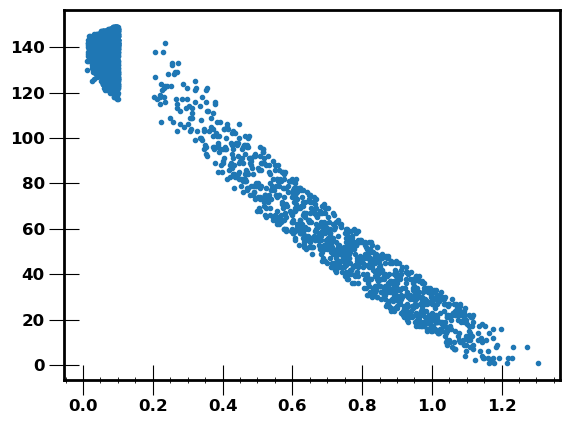

In [26]:
plt.scatter(specs.groupby(['spec']).z.first(), specs.groupby(['spec']).index.count(), marker=".")

In [27]:
nb_pts = specs.groupby(['spec']).index.count()

In [28]:
nb_pts[nb_pts < 10]

spec
HSC_spec_4621     8
HSC_spec_4633     4
HSC_spec_4658     1
HSC_spec_4664     2
HSC_spec_4701     8
HSC_spec_4731     8
HSC_spec_4768     3
HSC_spec_4773     2
HSC_spec_4790     3
HSC_spec_4806     1
HSC_spec_4809     9
SNLS_spec_3638    7
SNLS_spec_3710    3
SNLS_spec_3714    3
SNLS_spec_3727    9
SNLS_spec_3771    8
SNLS_spec_3810    9
SNLS_spec_3839    3
SNLS_spec_3846    9
SNLS_spec_3880    6
SNLS_spec_3911    8
SNLS_spec_3916    6
SNLS_spec_3928    1
SNLS_spec_3990    7
SNLS_spec_4112    7
SNLS_spec_4113    7
SNLS_spec_4135    3
SNLS_spec_4159    6
SNLS_spec_4195    1
SNLS_spec_4237    3
SNLS_spec_4414    4
SNLS_spec_4488    9
Name: index, dtype: int64

In [29]:
clean.tds.spec_data.nt[clean.tds.spec_data.spec=='SNLS_spec_3928']

rec.array([(51889, 'SNLS_3619', 'SNLS_spec_3928', 53858.30078125, 1.16415, 1, nan, 4351.75879397, 53, 0.72907259, 2.56666813, 426.89374425, 298, 6.53579796, 14.14444714, 2.34715127)],
          dtype=[('index', '<i8'), ('sn', 'O'), ('spec', 'O'), ('mjd', '<f8'), ('z', '<f8'), ('valid', '<i8'), ('exptime', '<f8'), ('wavelength', '<f8'), ('i_basis', '<i8'), ('flux', '<f8'), ('fluxerr', '<f8'), ('chi2', '<f8'), ('ndof', '<i8'), ('median_restframe_dwl', '<f8'), ('median_dwl', '<f8'), ('fluxerr_variability', '<f8')])

In [291]:
clean._recalib_and_clean_spectra()

2025-04-14 16:43:52 INFO root - recalib and clean spectra
2025-04-14 16:43:52 INFO root - ignoring 0 points with buggy flux errs
2025-04-14 16:43:56 INFO root - 93 outliers detected at the level of 20 sigmas
2025-04-14 16:43:56 INFO root - update flags: 93 outliers flagged
2025-04-14 16:43:56 INFO root - updating SpectrumRecalibration parameters


In [30]:
tds.spec_data.spec_set[3730]

'ZTF_spec_2997'

2025-04-15 16:35:51 INFO nacl.dataset - HSC_3746 57816.26171875 1.1082500219345093


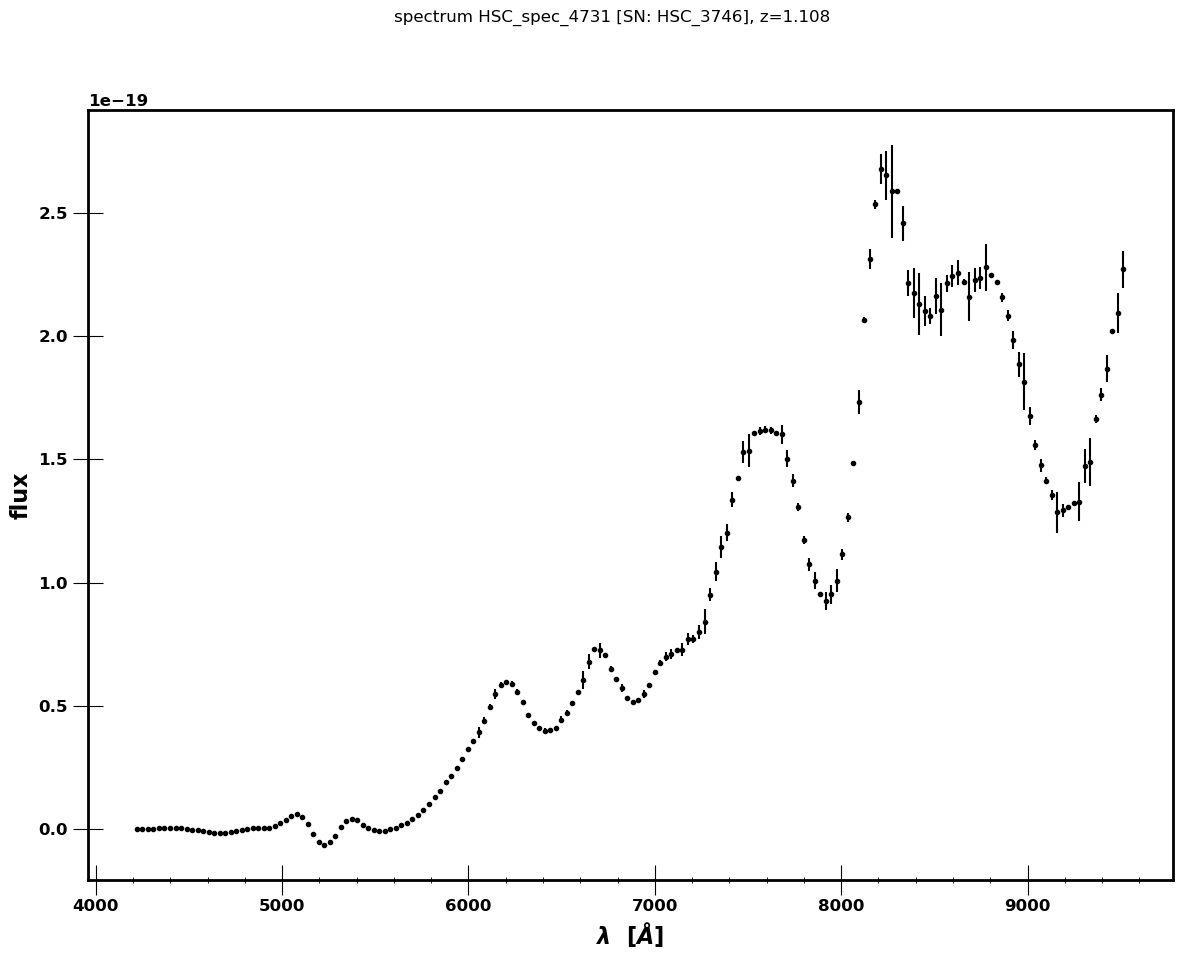

In [40]:
tds_no_comp.plot_spectrum('HSC_spec_4731')

2025-04-15 16:35:29 INFO nacl.dataset - HSC_3746 57816.26171875 1.1082500219345093


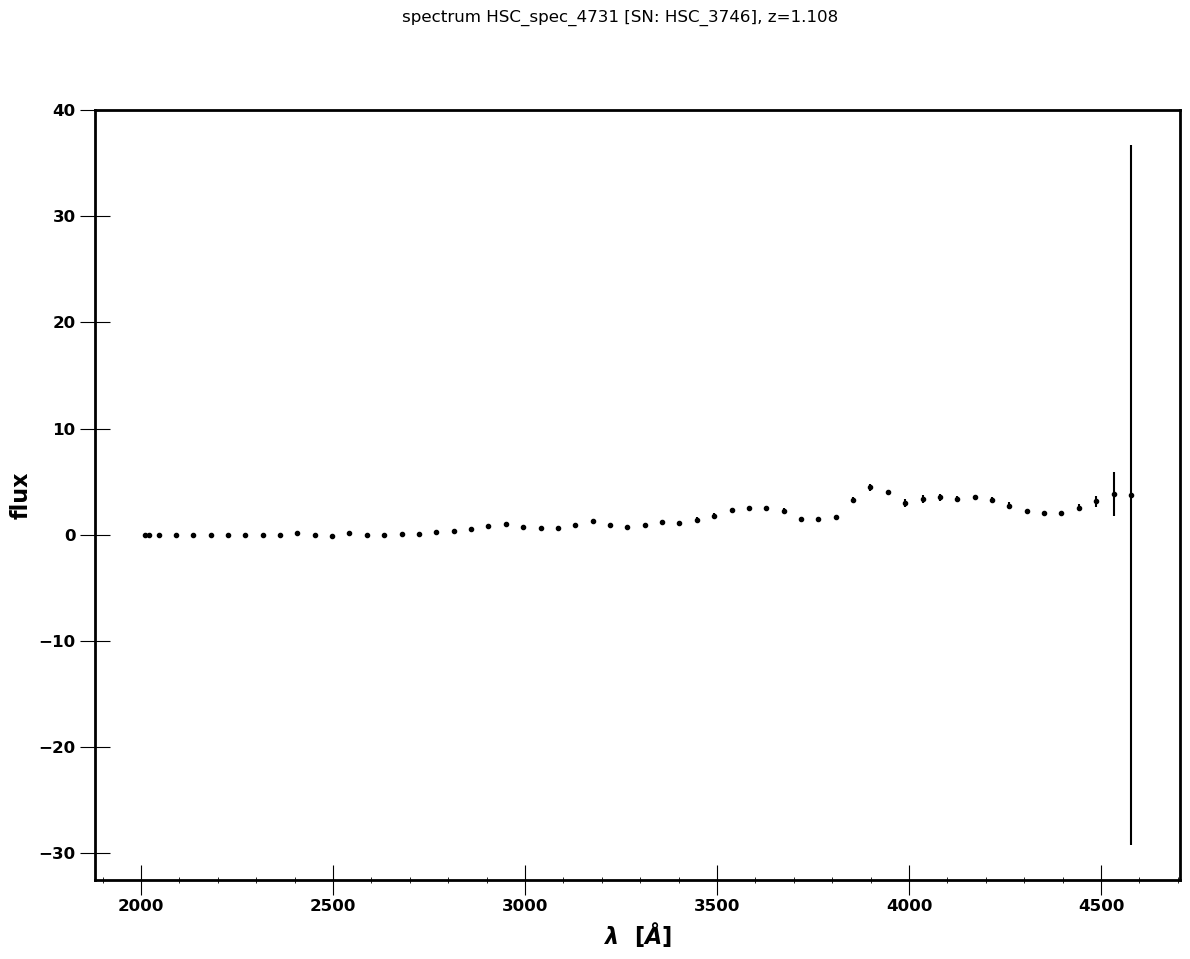

In [38]:
tds.plot_spectrum('HSC_spec_4731')

2025-04-15 16:35:37 INFO nacl.dataset - HSC_3746 57816.26171875 1.1082500219345093


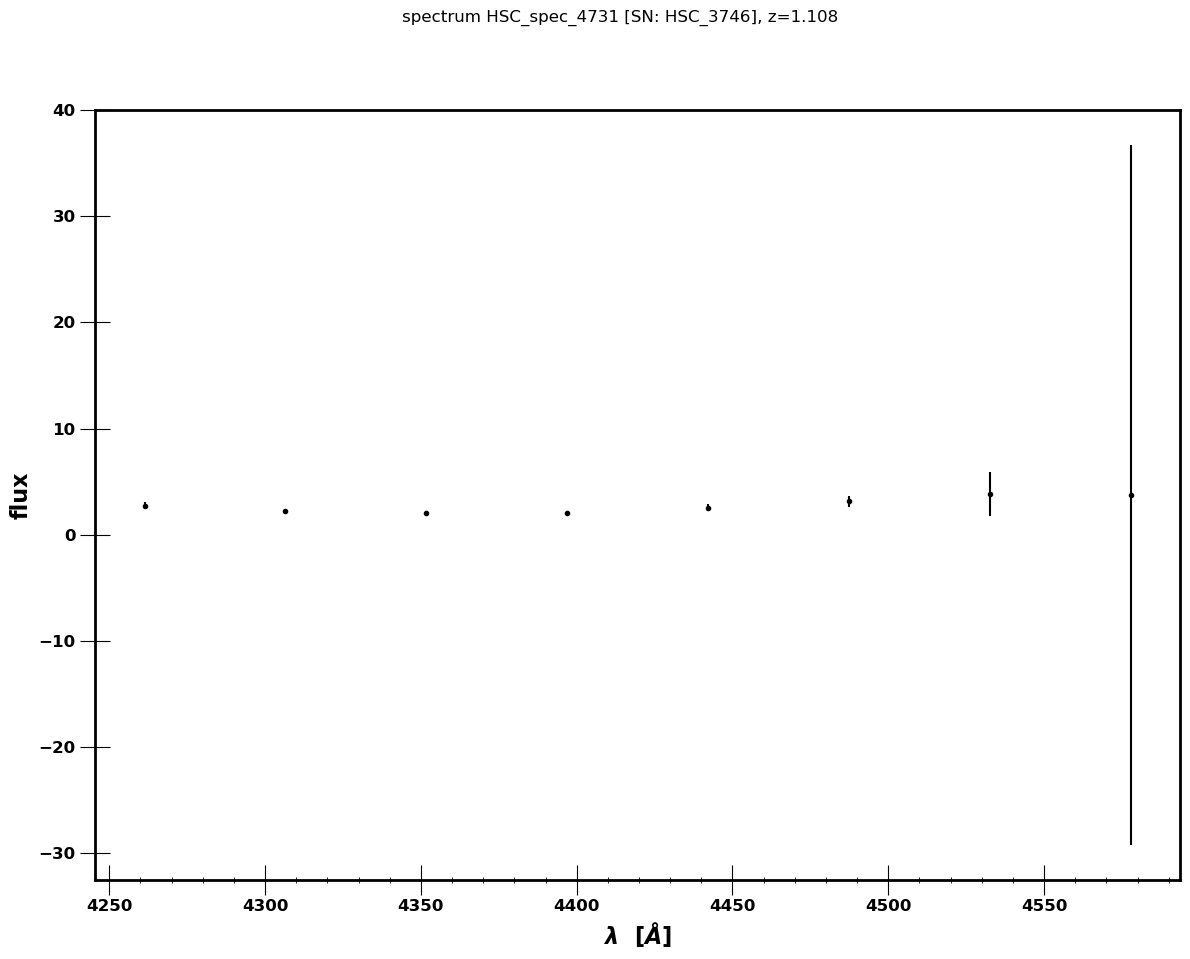

In [39]:
clean.tds.plot_spectrum('HSC_spec_4731')

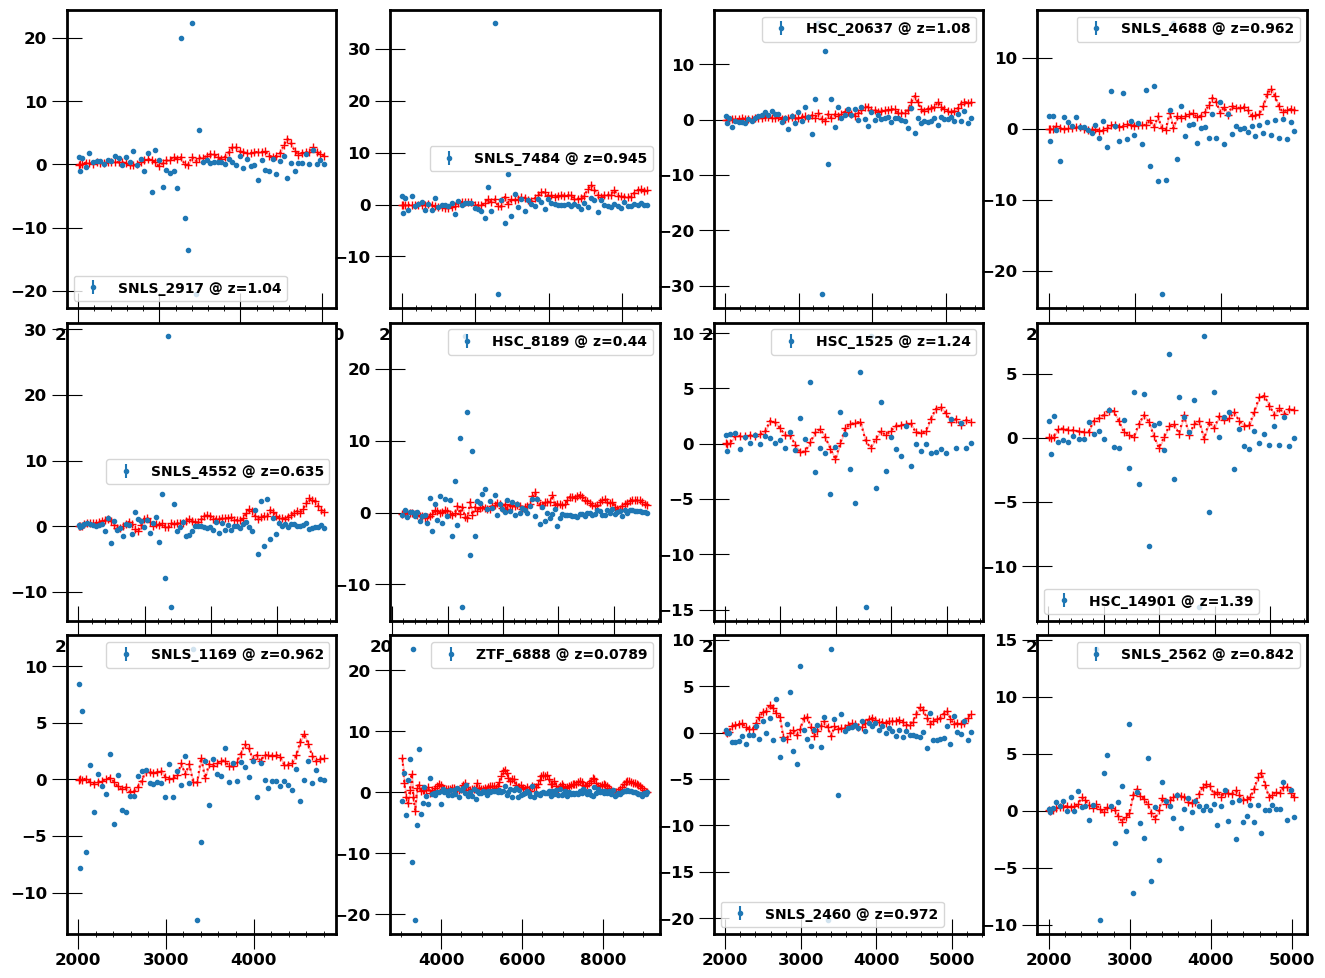

In [293]:
clean.plot_spectra(nspec=12, pulls=True)

In [288]:
import saltworks.linearmodels as lm
model = lm.LinearModel(J.row, J.col, J.data, name='recal')
solver = lm.RobustLinearSolver(model, r, weights=1/r_err, verbose=True)
p = solver.robust_solution(nsig=nsig)
logging.info(f'{solver.bads.sum()} outliers detected at the level of {nsig} sigmas')

2025-04-14 16:42:44 INFO root - 93 outliers detected at the level of 20 sigmas


In [ ]:
clean.plot_spectra(nspec=12, pulls=True)

In [38]:
fit_lc=pandas.read_pickle('/cfs/data/angi0819/Projet_LPNHE/georges_results/mock_0.1/0/all/nacl/1_lcfit/distillate.pkl')

2025-04-09 15:45:14 INFO nacl.dataset - indexing light curves
2025-04-09 15:45:14 INFO nacl.dataset - indexing spectra
2025-04-09 15:45:14 WARNING nacl.dataset - _index_spectra: no spectra no index - pass
2025-04-09 15:45:14 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-04-09 15:45:14 INFO nacl.models.salt2.salt - user provided grid in phase
2025-04-09 15:45:14 INFO nacl.models.salt2.salt - initializing lightcurve eval unit
2025-04-09 15:45:14 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(

2025-04-09 15:45:14 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-04-09 15:45:14 INFO nacl.models.salt2.salt - user provided grid in phase
2025-04-09 15:45:15 INFO nacl.dataset - indexing light curves
2025-04-09 15:45:15 INFO nacl.dataset - indexing spectra
2025-04-09 15:45:15 WARNING nacl.dataset -

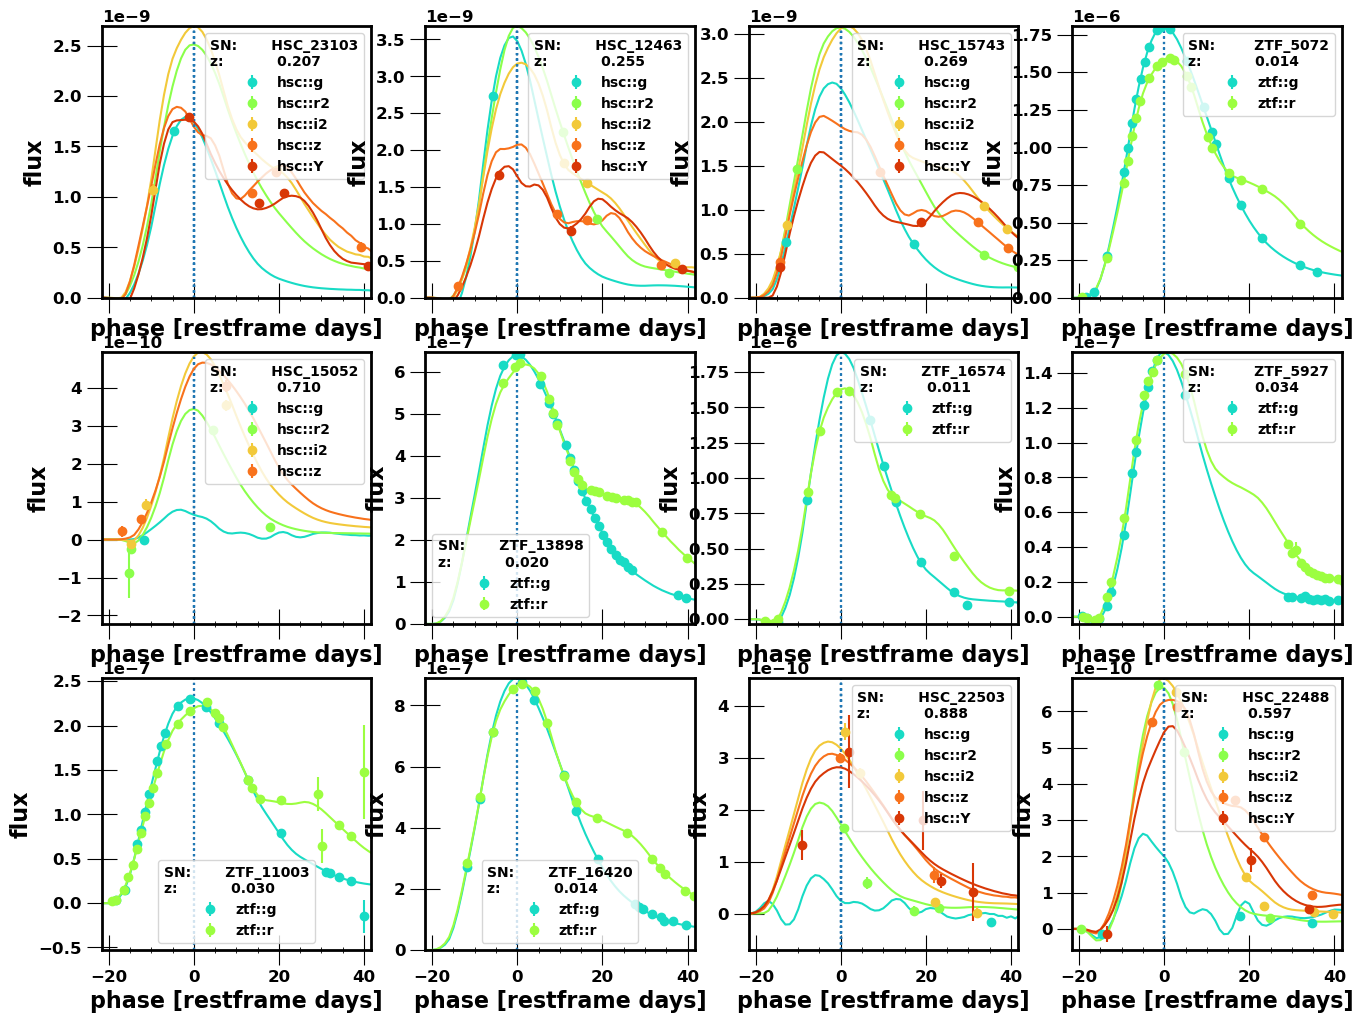

In [42]:
fit_lc.plot_lcs(nsn=12)

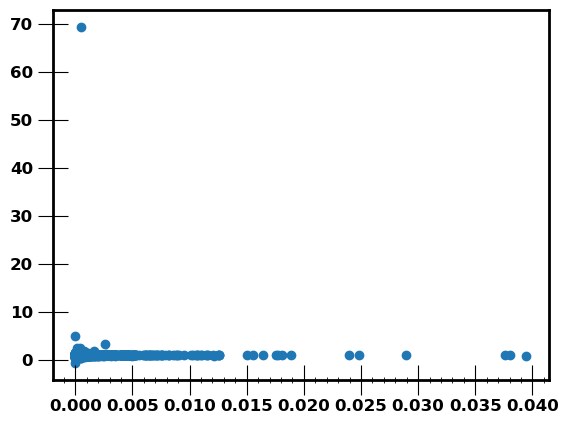

In [50]:
plt.scatter(fit_lc.initial_pars['X0'].full, fit_lc.initial_pars['X0'].full/fit_lc.pars['X0'].full)

In [75]:
(fit_lc.initial_pars['X0'].full/fit_lc.pars['X0'].full).argmax(), fit_lc.tds.sn_data.sn_set[1975]

(1975, 'ZTF_3865')

2025-04-09 15:52:50 INFO nacl.dataset - indexing light curves
2025-04-09 15:52:50 INFO nacl.dataset - indexing spectra
2025-04-09 15:52:50 WARNING nacl.dataset - _index_spectra: no spectra no index - pass
2025-04-09 15:52:50 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-04-09 15:52:50 INFO nacl.models.salt2.salt - user provided grid in phase
2025-04-09 15:52:50 INFO nacl.models.salt2.salt - initializing lightcurve eval unit
2025-04-09 15:52:50 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/georges/lib/python3.12/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(

2025-04-09 15:52:50 INFO nacl.models.salt2.salt - user provided grid in wavelength
2025-04-09 15:52:50 INFO nacl.models.salt2.salt - user provided grid in phase


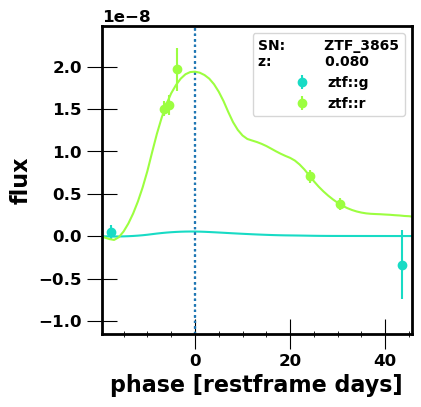

In [76]:
fit_lc.plot_lcs(sn_index=1975)

## SNe Generation from 2M++

### ZTF

In [37]:
class SNeIa_full_bgs(Transient):

    _KIND = "SNIa"
    _RATE = 2.35 * 10**4 # /yr/Gpc^3 Perley 2020
    _COSMOLOGY = cosmo

    def __init__(self,
                 path=None,
                 filename="Uchuu.csv",
                 salt_path=None,
                 date_range=[58179, 59215],
                 zmax=0.06,
                 extinction=True):
        super().__init__()
        # {'model': func, 'prop': dict, 'input':, 'as':}
        self.galaxy_positions = load_bgs(path=path, filename=filename)
        self.set_model(dict(
            x1={"func": SNeIaStretch.nicolas2021},
            c={"func": SNeIaColor.intrinsic_and_dust},
            t0={"func": np.random.uniform, "kwargs": {"low": date_range[0], "high": date_range[1]}},
            magabs={
                "func": SNeIaMagnitude.tripp1998,
                "kwargs": {"x1": "@x1", "c": "@c", "mabs": -19.3, "sigmaint": 0.10},
            },
            magobs={
                "func": "magabs_to_magobs",  # defined in Target (mother of Transients)
                "kwargs": {"z": "@z_cosmo", "magabs": "@magabs"},
            },
            x0={
                "func": "magobs_to_amplitude",  # defined in Transients
                "kwargs": {"magobs": "@magobs", "param_name": "x0"},
            },  # because it needs to call sncosmo_model.get(param_name)
            radecz={
                "func": rand_positions,
                "kwargs": {"positions": self.galaxy_positions, 'zcut': zmax},
                "as": ["ra", "dec", "z", "host_id", "z_cosmo"],
            },
        ))
        
        if salt_path:
            source = sncosmo.SALT2Source(modeldir=salt_path,
                                         m0file='nacl_m0_test.dat',
                                         m1file='nacl_m1_test.dat',
                                         clfile='nacl_color_law_test.dat')
        else:
            source = sncosmo.get_source('salt2', version='2.4')
        
        if extinction:
            model = sncosmo.Model(source=source, effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])
            self.set_model({**self.model.model,
                            "mwebv":{"func": milkyway.get_mwebv, "kwargs": {"ra": "@ra", "dec": "@dec"}},})
        else:
            model= sncosmo.Model(source=source)
        self.set_template(model)
        
        self.area=self.get_effective_area()
        # USE THIS AREA WHEN DRAWING TO ACCOUNT FOR THE CATALOG FOOTPRINT
        # e.g. SNeIa_full_bgs().draw(skyarea=SNeIa_full_bgs().area)

    def get_effective_area(self):
        nside = 2**(np.int32(np.log2(np.sqrt(self.galaxy_positions.shape[0]/(10*12))))-1)
        id_bgs = ang2pix(theta=np.pi / 2 - self.galaxy_positions["dec"] * np.pi / 180,
                            phi=self.galaxy_positions["ra"] * np.pi / 180,
                            nside=nside)

        mask = np.zeros(nside2npix(nside), dtype=bool)
        for i in id_bgs:
            mask[i] = True

        return np.sum(mask)*nside2pixarea(nside, degrees=True)


In [38]:
survey=extract_ztf()

snia = SNeIa_full_bgs(filename="/cfs/home/angi0819/Projet-LPNHE/Projet-LPNHE/data/2M++_subhalo_0.csv",
                      date_range=survey.date_range,
                      zmax=0.1,)
# snia.cosmology=cosmo
_ = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1],
              zmax=0.1,
              skyarea=snia.area,
              inplace=True)

2025-04-22 18:50:16 INFO ZTFxUchuu - Loading ZTF survey
2025-04-22 18:50:24 INFO ZTFxUchuu - Found .csv file at /cfs/home/angi0819/Projet-LPNHE/Projet-LPNHE/data/2M++_subhalo_0.csv with columns Index(['pos_x', 'pos_y', 'pos_z', 'vx', 'vy', 'vz', 'M200c', 'halo_id', 'Rmax',
       'd_c', 'vpec', 'z_cosmo', 'z', 'ra', 'dec'],
      dtype='object')
2025-04-22 18:50:24 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/lemaitre/lib/python3.10/site-packages/skysurvey/target/core.py:1001: UserWarning: skyarea given but no model have skyarea as parameters. This is ignored.
  warnings.warn("skyarea given but no model have skyarea as parameters. This is ignored.")



In [43]:
survey.data.band.replace({'ztfi':'ztf::I', 'ztfr':'ztf::r', 'ztfg':'ztf::g'}, inplace=True)

In [48]:
import os
nthreads=12
os.environ['OMP_NUM_THREADS'] = str(nthreads)
os.environ['MKL_NUM_THREADS'] = str(nthreads)
os.environ['OPENBLAS_NUM_THREADS'] = str(nthreads)
os.environ['NUMEXPR_NUM_THREADS'] = str(nthreads)


In [49]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey, incl_error=True, discard_bands=True)

2025-04-22 18:56:47 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/lemaitre/lib/python3.10/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")



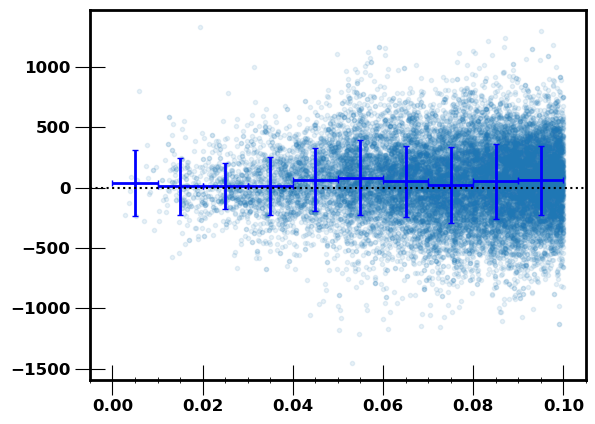

In [51]:
z_max = 0.1
n_bins = 10
width = z_max/n_bins
bounds = np.linspace(0.00, z_max-width, n_bins)
pv = (dset.targets.data.z - dset.targets.data.z_cosmo)*1e-3*c/(1+dset.targets.data.z_cosmo)
in_bins = [(dset.targets.data.z > z_min) & (dset.targets.data.z < z_min + width) for z_min in bounds]
plt.scatter(dset.targets.data.z,
            pv,
            marker=".",
            alpha=0.1,
           )


plt.errorbar(bounds + width/2,
             [pv[filt].mean() for filt in in_bins],
             yerr=[pv[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='blue',
             linewidth=2,
             alpha=1,
             capsize=2)
plt.axhline(0, color="k", linestyle=":")

In [50]:
with open('/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl', 'wb') as file:
    pickle.dump(dset.targets.data, file)
    pickle.dump(dset.data.rename(columns={'mjd':'time'}), file)

2025-04-22 19:01:01 WARNING root - Pandas support in corner is deprecated; use ArviZ directly


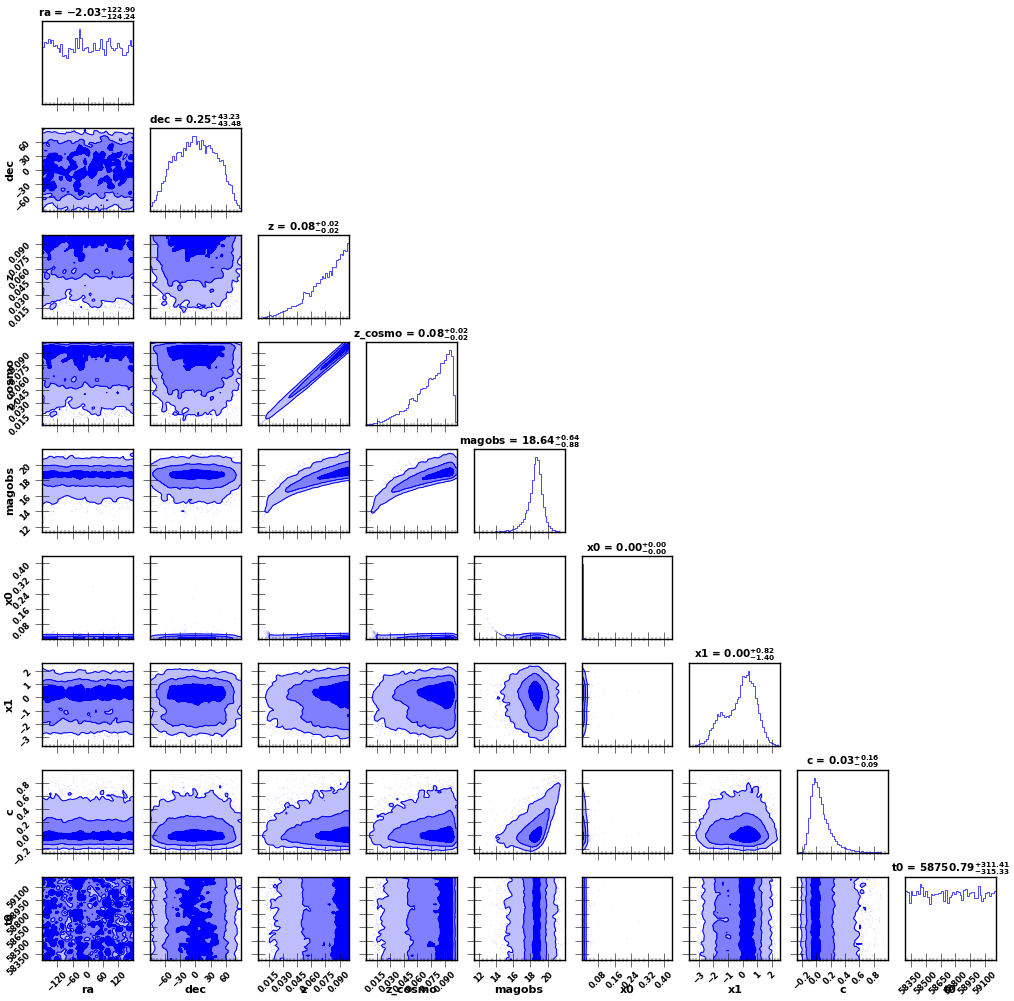

In [52]:
_=corner_(dset.targets.data, var_names=["ra","dec","z","z_cosmo","magobs","x0","x1","c","t0"])
plt.tight_layout()

### HSC/SNLS

In [76]:
class SNeIa( skysurvey.SNeIa ):

    _COSMOLOGY=cosmo
    
snia = SNeIa()


In [82]:
survey = extract_hsc()

2025-04-22 19:09:26 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/lemaitre/lib/python3.10/site-packages/skysurvey/survey/polygon.py:167: UserWarning: You do not have polars installed. conda/pip install polars. falling back to pandas backend
  warnings.warn("You do not have polars installed. conda/pip install polars. falling back to pandas backend")



In [83]:
from skysurvey.effects.milkyway import mwebv_model
snia.update_model(t0={"func":np.random.uniform,
                      'kwargs':{'low':survey.date_range[0], 'high':survey.date_range[1]}}, 
                  redshift={"kwargs": {'zmax': 1.6,}, 'as':'z'},
                  **mwebv_model)

In [84]:
snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1],
          skyarea=survey.get_skyarea().buffer(0.01), zmax=1.6,
          inplace=True)

,z,x1,c,t0,ra,dec,magabs,mwebv,magobs,x0,template
0,1.08365,-0.300,-0.162,58423.453125,150.394135,1.761302,-19.669704,0.023143,24.697943,2.096370e-06,salt2
1,1.46745,-0.515,0.143,59735.460938,36.446198,-5.121123,-18.799049,0.032317,26.381308,4.447558e-07,salt2
2,1.04215,0.380,0.169,58496.093750,149.858749,1.991762,-18.855330,0.023940,25.407621,1.090426e-06,salt2
3,0.84635,0.700,-0.135,58623.000000,149.710159,1.036804,-19.737507,0.033021,23.968496,4.104370e-06,salt2
4,1.53485,-1.115,-0.015,59836.800781,151.336609,1.569233,-19.155199,0.040266,26.145290,5.527501e-07,salt2
...,...,...,...,...,...,...,...,...,...,...,...
23868,1.47355,-0.485,-0.017,59108.863281,150.989380,1.957604,-19.227537,0.032216,25.963921,6.532453e-07,salt2
23869,1.29015,-0.565,0.041,59086.128906,151.401993,1.008236,-19.003132,0.040062,25.832275,7.374538e-07,salt2
23870,1.24475,0.725,0.110,58360.226562,35.636986,-3.241563,-19.037781,0.032224,25.701574,8.317923e-07,salt2
23871,0.73195,-0.760,-0.081,57785.218750,149.208420,2.237279,-19.389872,0.025940,23.929296,4.255261e-06,salt2


In [85]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey, discard_bands=True)

2025-04-22 19:09:53 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/lemaitre/lib/python3.10/site-packages/skysurvey/dataset.py:683: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()



In [86]:
with open('/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl', 'wb') as file:
    pickle.dump(dset.targets.data, file)
    pickle.dump(dset.data.rename(columns={'mjd':'time'}), file)

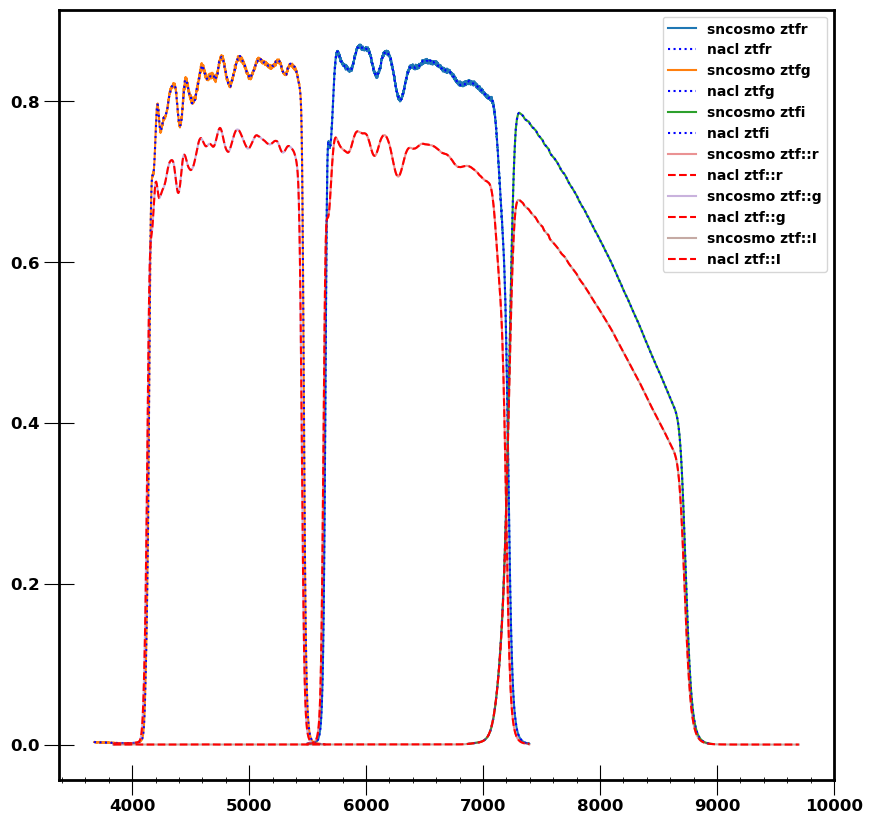

In [35]:
plt.figure(figsize=(10,10))
for b in ['ztfr', 'ztfg', 'ztfi',
        # 'MEGACAM6::g', 'MEGACAM6::r', 'MEGACAM6::i2', 'MEGACAM6::z', 'MEGACAM6::i', 'MEGACAM6::i2',
          # 'hsc::y', 'hsc::i2', 'hsc::g', 'hsc::r2', 'hsc::z',
         ]:
    band_sncosmo = sncosmo.get_bandpass(b)
    band_nacl = filterlib.get_bandpass(b, average=True)
    norm = band_sncosmo.trans.max()
    plt.plot(band_sncosmo.wave, band_sncosmo.trans, label='sncosmo '+b)
    plt.plot(band_sncosmo.wave, band_nacl(band_sncosmo.wave), color='b', label='nacl '+b, linestyle=':')
    # plt.plot(band_sncosmo.wave, band_sncosmo.trans - band_nacl(band_sncosmo.wave), label='diff '+b, alpha=0.3)

for b in ['ztf::r', 'ztf::g', 'ztf::I',
          # 'megacam6::g', 'megacam6::i2', 'megacam6::r', 'megacam6::z', 'megacam6::i', 'megacam6::i2',
          # 'hsc::Y',
         ]:
    band_sncosmo = sncosmo.get_bandpass(b)
    band_nacl = filterlib.get_bandpass(b, average=True)
    norm = band_sncosmo.trans.max()
    plt.plot(band_sncosmo.wave, band_sncosmo.trans, label='sncosmo '+b, alpha=0.5)
    plt.plot(band_sncosmo.wave, band_nacl(band_sncosmo.wave), color='r', label='nacl '+b, linestyle='--')
    # plt.plot(band_sncosmo.wave, band_sncosmo.trans - band_nacl(band_sncosmo.wave), label='diff '+b, alpha=0.3)


plt.legend()
    

In [150]:
tds.band_wavelength.keys()

dict_keys(['hsc::Y', 'hsc::g', 'hsc::i2', 'hsc::r2', 'hsc::z', 'megacam6::g', 'megacam6::i2', 'megacam6::r', 'megacam6::z', 'ztf::I', 'ztf::g', 'ztf::r'])

In [145]:
tds = TrainingDataset.read_parquet("/cfs/data/angi0819/Projet_LPNHE/georges_results/full_mock/0/tds/tds_all.parquet", filterlib=filterlib)

2025-04-22 17:25:58 INFO nacl.dataset - indexing light curves
2025-04-22 17:25:59 INFO nacl.dataset - indexing spectra


### Spectra

In [ ]:
data, lc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_snls.pkl", survey='SNLS')

In [ ]:
lc = lc[(lc.time.between(data.loc[lc.name, 't0'] - 50, data.loc[lc.name, 't0'] + 100))].copy()
lc['valid'] = (lc.flux/lc.fluxerr>5)

In [ ]:
# Select SN on : >=5 detections in >=2 bands
goods_sn = (lc[lc.valid].groupby(["name"]).band.nunique() >= 2) & \
           (lc[lc.valid].groupby(["name"])['flux'].count() >= 5) & \
           (lc[lc.valid][lc[lc.valid].time < data.loc[lc[lc.valid].name, "t0"]].groupby("name").flux.count() >= 2) & \
           (lc[lc.valid][lc[lc.valid].time > data.loc[lc[lc.valid].name, "t0"]].groupby("name").flux.count() >= 2)

In [ ]:
lc = lc[lc.name.isin(goods_sn[goods_sn].index)]

data = data[data.name.isin(lc.name.unique())]

In [ ]:
snia = skysurvey.SNeIa.from_data(data)
snia.update_model(#t0={"func":np.random.uniform, 'kwargs':{'low':survey.date_range[0], 'high':survey.date_range[1]}},
                  redshift={"kwargs": {'zmax':1.6,}, 'as':'z'},
                  mwebv={"func": skysurvey.effects.milkyway.get_mwebv, "kwargs": {"ra": "@ra", "dec": "@dec"}},)

source = sncosmo.get_source('salt2', version='2.4')
model= sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])

snia.set_template(model)

In [ ]:
output = lc.loc[data.index].join(data.drop(columns=["sn", "survey", "name"])).drop(columns=['template'])
output['snid'] = output.index

In [ ]:
from mocksurvey.simulations import (
    get_luminosity_distance,
    get_effective_wavelength,
    get_snr,
    build_band_index,
    discard_small_snr,
    discard_skysurvey_flux,
    eliminate_points_not_in_model,
    get_trueflux_and_amplitude,
    get_sn_position,
)

output = get_luminosity_distance(output, snia)
output = get_effective_wavelength(output)

output = eliminate_points_not_in_model(output, snia)
output.to_csv("./outdir/mock_survey.csv", index=False)

In [ ]:
output = get_trueflux_and_amplitude(output, snia)

In [ ]:
output = get_snr(output)

In [ ]:
output = discard_small_snr(output, threshold=0)

In [ ]:
output = discard_skysurvey_flux(output)

In [ ]:
def plot_lc_index(index, lc_data, sne_data=None):
    """
    My plotting for lightcurve because I was tired of having to put everything in a skysurvey dataset.
    """
    if sne_data is not None:
        model.set(z=sne_data.loc[index, 'z'],
                  x0=sne_data.loc[index, 'x0'],
                  x1=sne_data.loc[index, 'x1'],
                  c=sne_data.loc[index, 'c'],
                  mwebv=sne_data.loc[index, 'mwebv'],
                  mwr_v=3.1,t0=0)  # set the model's redshift and MW

        if "tmax" in sne_data.columns:
            t0 = sne_data.loc[index, "tmax"]
            err_t0 = sne_data.loc[index, "err_tmax"]
            plt.axvline(t0, color="r", label=r"$t_0$")
            plt.axvline(t0 - err_t0, color="r", linestyle=":")
            plt.axvline(t0 + err_t0, color="r", linestyle=":")
        else:
            t0 = sne_data.loc[index, "t0"]
            plt.axvline(t0, color="r", label=r"$t_0$")

    for b in np.unique(lc_data[(lc_data.name==index) & (lc_data.valid==1)].band):
        lc = lc_data[(lc_data.band==b) & (lc_data.name==index)].sort_values(by='mjd')
        coef = 10 ** (-(lc["zp"] - 25) / 2.5)
        plt.errorbar(lc["mjd"],
                     lc["flux"]*coef,
                     yerr=lc["fluxerr"]*coef,
                     linestyle='',
                     marker='.',
                     color=color_band[b],
                     label=b
                    )
        if sne_data is not None:
            times = np.linspace(-20, 50, 1000)
            plt.plot(times+t0, model.bandflux(b, times, zp=25, zpsys="AB"), color=color_band[b])

        
    plt.title(f"SN {index}")
    plt.legend()



In [ ]:
output = get_sn_position(output)

In [ ]:
output.to_csv("./outdir/mock_survey.csv", index=False)

In [ ]:
output=pandas.read_csv('./outdir/mock_survey.csv')

In [ ]:
def f(x, a, b, c):
    """ """
    return a * x**2 + b * x + c
data_sim = []

idx = output["fluxtrue"] != 0
output = output[idx]

mock_snid = np.unique(output["snid"])

length_wave = np.array([218, 437, 3258, 656, 868])
popt = np.array([-7.87649259e-07, 1.08382223e-02, -2.44390307e01])
a, b, c = popt

In [ ]:
for i,snid in tqdm(enumerate(mock_snid), total=len(mock_snid)):
    try:
        mock_sn = output[output["snid"] == snid]
        x0 = mock_sn.iloc[0]["x0"]
        x1 = mock_sn.iloc[0]["x1"]
        c = mock_sn.iloc[0]["c"]
        t0 = mock_sn.iloc[0]["t0"]
        z = mock_sn.iloc[0]["z"]
        mwebv = mock_sn.iloc[0]["mwebv"]
        
        wave_size = np.random.choice(length_wave)
        min_wave = np.random.uniform(2900.0, 3400.0)
        max_wave = np.random.uniform(9000.0, 11000.0)
        wavelength = np.linspace(min_wave, max_wave, wave_size)
        
        
        mjd = np.random.choice(mock_sn["time"][mock_sn["time"].between(t0 - 10, t0 + 40)])
        
        source = sncosmo.get_source('salt2', version='2.4')
        model= sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])
        p = {"z": z, "t0": t0, "x0": x0, "x1": x1, "c": c, "mwebv": mwebv, "mwr_v": 3.1}
        model.set(**p)
        
        min_w = model.minwave()
        max_w = model.maxwave()
        
        try:
            flux_true = model.flux(mjd, wavelength)
        except:
            try:
                wavelength = wavelength[wavelength < model.maxwave()]
                flux_true = model.flux(mjd, wavelength)
            except:
                wavelength = wavelength[wavelength > model.minwave()]
                flux_true = model.flux(mjd, wavelength)
        
        norm_values = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1e12])
        norm = np.random.choice(norm_values)
        flux_true *= norm
        flux_err = (flux_true / f(wavelength, a, b, c)) * np.random.randn(
            len(flux_true)
        )
        flux = flux_true + 0.5 * flux_err
        
        spec_sim = pandas.DataFrame(columns=["spec","time","wavelength","flux","fluxerr","valid","exptime","snid","flux_true","x0","x1","c","t0","mwebv","z"],
                                   dtype=('int','float'))
        spec_sim['wavelength'] = wavelength
        spec_sim['flux'] = flux
        spec_sim['flux_true'] = flux_true
        spec_sim['fluxerr'] = np.abs(flux_err)
        spec_sim['time'] = mjd
        spec_sim['valid'] = 1
        spec_sim['exptime'] = np.nan
        spec_sim['sn'] = mock_sn.iloc[0]["sn"]
        spec_sim['snid'] = snid
        spec_sim['spec'] = i
        spec_sim["z"] = z
        spec_sim["x0"] = x0
        spec_sim["x1"] = x1
        spec_sim["c"] = c
        spec_sim["t0"] = t0
        spec_sim["mwebv"] = mwebv
        data_sim.append(spec_sim)
    except ValueError as e:
        logging.info(f"No spectra could be generated for the sn {mock_sn.iloc[0]['sn']}")
        continue
spec = pandas.concat(data_sim)

In [ ]:
spec.to_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_snls.csv", index=False)

### TDS

In [ ]:
data_ztf, lc_ztf = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl", survey='ZTF')
data_hsc, lc_hsc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl", survey='HSC')
data_snls, lc_snls = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_snls.pkl", survey='SNLS')

In [ ]:
spec_ztf = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_2M++.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_ztf['survey'] = 'ZTF'
spec_hsc = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_hsc.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_hsc['survey'] = 'HSC'
spec_snls = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_snls.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_snls['survey'] = 'SNLS'
shift_sp_ztf, shift_sp_snls = spec_ztf.spec.max()+1, spec_snls.spec.max()+1
spec_snls.spec += shift_sp_ztf
spec_hsc.spec += shift_sp_ztf + shift_sp_snls

In [ ]:
data = pandas.concat([data_ztf, data_snls, data_hsc])
lc = pandas.concat([lc_ztf, lc_snls, lc_hsc])
spec = pandas.concat([spec_ztf, spec_snls, spec_hsc])
spec['name'] = spec.survey + '_' + spec.sn.astype(str)
spec.set_index('name', drop=False, inplace=True)

In [ ]:
# Select only points at 5 sigma and in [tmax-50, tmax+100]
lc = lc[(lc.flux/lc.fluxerr>5) &
                (lc.time.between(data.loc[lc.name, 't0'] - 50,
                                     data.loc[lc.name, 't0'] + 100))].copy()

# Select SN on : >=5 detections in >=2 bands
goods_sn = (lc.groupby(["name"]).band.nunique() >= 2) & \
           (lc.groupby(["name"])['flux'].count() >= 5) & \
           (lc[lc.time < data.loc[lc.name, "t0"]].groupby("name").flux.count() >= 2) & \
           (lc[lc.time > data.loc[lc.name, "t0"]].groupby("name").flux.count() >= 2)


In [ ]:
lc = lc[goods_sn.loc[lc.name]]
data = data[data.name.isin(lc.name.unique())]
spec = spec[spec.name.isin(lc.name.unique())]

In [ ]:
lc_dtype=np.dtype([
    ('sn', 'O'), ('mjd', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8'),
    ('band', 'O'), ('magsys', 'O'), ('exptime', '<f8'), ('valid', '<i8'),
    ('lc', 'O'), ('zp', '<f8'), ('mag_sky', '<f8'), ('seeing', '<f8'),
    ('x', '<f8'),('y', '<f8'), ('sensor_id', '<i8')])

N = len(lc)
lc_rec = np.recarray((N), dtype=lc_dtype)
lc_rec["sn"] = lc.name
lc_rec["mjd"] = lc.time
lc_rec["flux"] = lc.flux
lc_rec["fluxerr"] = lc.fluxerr
lc_rec["band"] = lc.band
lc_rec["zp"] = lc.zp
lc_rec["magsys"] = lc.zpsys
lc_rec["valid"] = np.ones(N)
lc_rec["lc"] = lc_rec["sn"] + "_" + lc_rec["band"]

In [ ]:
sn_dtype=np.dtype([
    ('sn', 'O'), ('z', '<f8'), ('tmax', '<f8'), ('x1', '<f8'),
    ('x0', '<f8'), ('c', '<f8'), ('mwebv', '<f8'), ('valid', '<i8'), ('IAU', 'O'), ('survey', 'O')])

N = len(data)
sn_rec = np.recarray((N), dtype=sn_dtype)
sn_rec["sn"] = data.name
sn_rec["z"] = data.z
sn_rec["x0"] = data.x0
sn_rec["x1"] = data.x1
sn_rec["c"] = data.c
sn_rec["tmax"] = data.t0
sn_rec["mwebv"] = data.mwebv
sn_rec["valid"] = np.ones(N)
sn_rec["survey"] = data.survey


In [ ]:
sp_dtype = np.dtype([
        ('sn', 'O'),
        ('mjd', '<f8'),
        ('wavelength', '<f8'),
        ('flux', '<f8'),
        ('fluxerr', '<f8'),
        ('i_basis', '<i8'),
        ('valid', '<i8'),
        ('spec', '<i8'),
        ('exptime', '<f8'),])
N = len(spec)
spec_rec = np.recarray((N), dtype=sp_dtype)

spec_rec['sn'] = spec.name
spec_rec['mjd'] = spec.time
spec_rec['wavelength'] = spec.wavelength
spec_rec['flux'] = spec.flux
spec_rec['fluxerr'] = spec.fluxerr
spec_rec['i_basis'] = np.zeros(N)
spec_rec['valid'] = spec.valid
spec_rec['spec'] = spec.spec
spec_rec['exptime'] = spec.exptime

In [ ]:
tds = TrainingDataset(sn_rec, lc_data=lc_rec, spec_data=spec_rec, filterlib=filterlib)

In [ ]:
tds.kill_sne(tds.sn_data.sn[tds.sn_data.z > 0.6])

In [ ]:
tds.compress()

In [ ]:
tds.to_parquet('tds_z0_6', path="./data/")

In [ ]:
tds = TrainingDataset.read_parquet('tds_z0_6', path="/cfs/data/angi0819/Projet_LPNHE/tds/tds_z0_6/")

In [ ]:

import os
import logging
import pathlib
import numpy as np
import pylab as pl
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from lccalib.averaging import plot_night_averager

from lemaitre.georges.make_dc_tds import MockData
from minipets import compa_hist, compa_bin, Dataset as PetsDataset

class MyMockData(MockData):
    """A class to handle access to the mock files

    This class allows accessing the mock files generated by the Data Challenge
    Simulation framework (based on skysurvey) in a uniform way. This class may
    be specialized by inheritance from DC to DC.

    It also does manage compression, as well as preliminary filtering of the
    dataset.

    """
    def __init__(self, mock, tds,
                 logger=None, logfile=None,
                 wlbasis_grid=None, filterlib=None,
                 true_sn_pars=None,
                 **kw):
        self.mock = mock
        if logfile is not None and logger is None:
            self._logfile = pathlib.Path(logfile) if logfile is not None else None
            logger = setup_logger(kw.get('log_level', 'debug'),
                                  self._logfile)
        sn_data = pd.DataFrame(tds.sn_data.nt)
        lc_data = pd.DataFrame(tds.lc_data.nt)
        spec_data = pd.DataFrame(tds.spec_data.nt)
        PetsDataset.__init__(self, sn_data=sn_data,
                       lc_data=lc_data,
                       spec_data=spec_data,
                       logger=logger,
                       flib=filterlib)
        self._wlbasis_grid = wlbasis_grid
        self.filterlib = filterlib
        self._true_sn_pars = true_sn_pars


In [ ]:
sn_data = pd.DataFrame(tds.sn_data.nt)
lc_data = pd.DataFrame(tds.lc_data.nt)
spec_data = pd.DataFrame(tds.spec_data.nt)

pets_tds = PetsDataset(sn_data=sn_data,
            lc_data=lc_data,
            spec_data=spec_data,
            logger=None,
            flib=None)

In [ ]:
pets_tds??

In [ ]:
from minipets import Dataset as PetsDataset
pets_tds = PetsDataset.from_nacl(tds)
pets_tds.dr2_like_cuts()
pets_tds.apply_cut()
pets_tds.get_tds().to_parquet('tds_z0_6_dr2_cuts', path="./data/")

### Trainer

In [ ]:
from nacl.tools import NaClTrainer
trainer = NaClTrainer('./data/tds_z0_6_dr2_cuts', '/cfs/data/angi0819/Projet_LPNHE/test/')

In [ ]:
v_init = trainer.model_initial(trainer.pars_initial)


In [ ]:
color_band = {"ztfi":"olive",
             "ztfr":"purple",
             "ztfg":"limegreen",
             "megacam6::z":"blue",
             "megacam6::r":"red",
             "megacam6::g":"green",
             "megacam6::i2":"orange",
             "hsc::Y":"turquoise",
             "hsc::g":"olivedrab",
             "hsc::i2":"gray", 
             "hsc::r2":"darkred",
             "hsc::z":"gold",
             }


In [ ]:
plt.figure(figsize=(20,20))
for b in np.unique(trainer.tds.lc_data.nt.band):
    plt.scatter(trainer.tds.lc_data.flux[trainer.tds.lc_data.band == b],
                v_init[:len(trainer.tds.lc_data.nt)][trainer.tds.lc_data.band == b],
                s=2,
           color=color_band[b], label=b)
plt.legend()
plt.loglog(*[[1e1, 1e6]]*2, ':k')


In [ ]:
from nacl.models.salt2 import DustExtinction
trainer.model_initial = SALT2Like(trainer.tds,
                            phase_grid=np.linspace(-50, 100., 150),
                            dust_extinction_model=DustExtinction().CCM89_dust())
trainer.pars_initial = trainer.model_initial.init_pars()


In [ ]:
trainer.clean()

In [ ]:
trainer.lc_fit()

In [ ]:
z_cosmo = mag_to_z(
    data[data.survey == "ZTF"].magobs
    + 0.14 * data[data.survey == "ZTF"].x1
    - 3.15 * data[data.survey == "ZTF"].c
)

In [ ]:
fit_lc = pandas.read_pickle('/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/distillate.pkl')

In [ ]:
v_init = fit_lc.initial_model(fit_lc.initial_pars)
v_fit = fit_lc.model(fit_lc.pars)


In [ ]:
plt.figure(figsize=(20,20))
for b in np.unique(fit_lc.tds.lc_data.nt.band):
    plt.scatter(fit_lc.tds.lc_data.flux[fit_lc.tds.lc_data.band == b],
                v_fit[:len(fit_lc.tds.lc_data.nt)][fit_lc.tds.lc_data.band == b],
                s=2,
           color=color_band[b], label=b)
plt.legend()
plt.loglog(*[[1e1, 1e6]]*2, ':k')


In [ ]:
plt.figure(figsize=(20,20))
for b in np.unique(fit_lc.tds.lc_data.nt.band):
    plt.scatter(fit_lc.tds.lc_data.flux[fit_lc.tds.lc_data.band == b],
                np.abs(v_fit[:len(fit_lc.tds.lc_data.nt)][fit_lc.tds.lc_data.band == b] - v_init[:len(fit_lc.tds.lc_data.nt)][fit_lc.tds.lc_data.band == b]),
                s=2,
           color=color_band[b], label=b)
plt.legend()
plt.loglog(*[[1e1, 1e6]]*2, ':k')


In [ ]:
sn_data = pandas.DataFrame(data=fit_lc.tds.sn_data.nt)
columns_rename = {'x0':'x0_init', 'x1':'x1_init', 'c':'c_init', 'tmax':'tmax_init'}
sn_data = sn_data.rename(columns = columns_rename)
sn_data = sn_data.assign(x0 = fit_lc.pars['X0'].full[fit_lc.tds.sn_data.sn_index])
sn_data = sn_data.assign(x1 = fit_lc.pars['X1'].full[fit_lc.tds.sn_data.sn_index])
sn_data = sn_data.assign(c = fit_lc.pars['c'].full[fit_lc.tds.sn_data.sn_index])
sn_data = sn_data.assign(t0 = fit_lc.pars['tmax'].full[fit_lc.tds.sn_data.sn_index])
sn_data['name'] = sn_data.sn
sn_data.to_parquet('/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/' + 'output_params' + '.parquet')


In [ ]:
fit_lc.plot_lcs(nsn=12)
plt.tight_layout()

In [ ]:
sn_data['magobs'] = -2.5*np.log10(sn_data.x0)
sn_data["mu"] = sn_data.magobs + 0.14*sn_data.x1 - 3.15*sn_data.c

In [ ]:
cov = fit_lc.covmat
iii = np.hstack([fit_lc.tds.sn_data.sn_index + i * len(fit_lc.tds.sn_data) for i in range(4)])
cov_reduced = cov[:, iii][iii]
np.save('/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/' + 'output_cov' + '.npy', cov_reduced.toarray())

In [ ]:
for s in sn_data.survey.unique():
    plt.scatter(sn_data[sn_data.survey==s].z, sn_data[sn_data.survey==s].mu, color=survey_colors[s], marker=".", label=s)
plt.legend()

### Edris

In [ ]:
from edris.georgesutils import CosmoFitter

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
fitter = CosmoFitter(
    '/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/' + "output_params.parquet",
    '/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/' + "output_cov.npy",
    niter=1000,
    lmbda=1e4,
    tol=1e-2,
    max_iter_tncg=None,
    n_bins=21,
    verbose=True,  # TODO make edris use standard logging
    output_save_path='/cfs/data/angi0819/Projet_LPNHE/test/')


In [ ]:
from lemaitre.georges.distance_comparison import compare_mu
compare_mu('/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/output_params.parquet', '/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/output_cov.npy',
           '/cfs/data/angi0819/Projet_LPNHE/test/flcdm_edris_output.pkl', true_alpha=0.14, true_beta=3.15,
           edris_cuts_index=(df.cut == 'is_ok').values,savefig_path='/cfs/data/angi0819/Projet_LPNHE/test/')


In [30]:
with open('/cfs/data/angi0819/Projet_LPNHE/test/flcdm_edris_output.pkl', 'rb') as fin:
    edris_res = pickle.loads(fin.read())


In [31]:
edris_res.keys()

dict_keys(['res', 'res_cov', 'loss', 'lambda', 'iter_params'])

In [37]:
df= pandas.read_csv('/cfs/data/angi0819/Projet_LPNHE/test/quality_cuts_edris.dat', delimiter=r'\s+', skiprows=2).rename(columns={'#end':'cut'})

In [8]:
nacl_fit = pandas.read_parquet('/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/output_params.parquet')

In [9]:
data, lc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl", survey="ZTF")

In [10]:
source = sncosmo.get_source('salt2', version='2.4')

In [11]:
model = sncosmo.Model(source)

In [12]:
snia = skysurvey.SNeIa()

In [39]:
nacl_fit.set_index('sn', inplace=True, drop=False)

In [40]:
nacl_fit["valid"] = (df['cut']=='is_ok')

In [41]:
nacl_fit['mu'] = -2.5*np.log10(nacl_fit.x0) - edris_res['res']['coef'][0]*nacl_fit.x1 - edris_res['res']['coef'][1]*nacl_fit.c

In [42]:
nacl_fit['mu_init'] = -2.5*np.log10(nacl_fit.x0_init) + 0.14*nacl_fit.x1_init - 3.15*nacl_fit.c_init

In [43]:
nacl_fit.loc[nacl_fit.valid, 'mu'] = -2.5*np.log10(nacl_fit[nacl_fit.valid].x0) - edris_res['res']['coef'] @ edris_res['res']['variables']

In [32]:
n = {k1:edris_res['res_cov'][k1][k1].shape[1] for k1 in edris_res['res_cov'].keys()}
cov = jnp.vstack([np.hstack([edris_res['res_cov'][k1][k2].reshape(n[k1], n[k2]) for k2 in edris_res['res_cov'].keys()]) for k1 in edris_res['res_cov'].keys()])

In [33]:
x0 = dict(M0=-(19.3 + source.peakmag(band="bessellb", magsys="ab")),
          Omega_m=cosmo.Om0,
          coef=jnp.array([-0.14, 3.15]),
          sigma_int=jnp.array([0.1]))

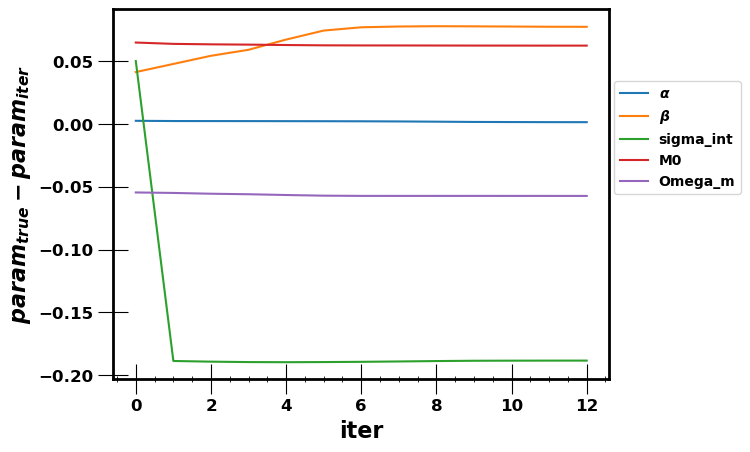

In [34]:
%matplotlib inline
for key in ["coef", 'sigma_int' , "M0", "Omega_m"]:
    plt.plot([iter_p[key]-x0[key] for iter_p in edris_res['iter_params']], label=[r'$\alpha$', r'$\beta$'] if key=='coef' else key)

plt.ylabel(r"$param_{true} - param_{iter}$")
plt.xlabel("iter")
plt.legend(loc=(1.01, 0.5))


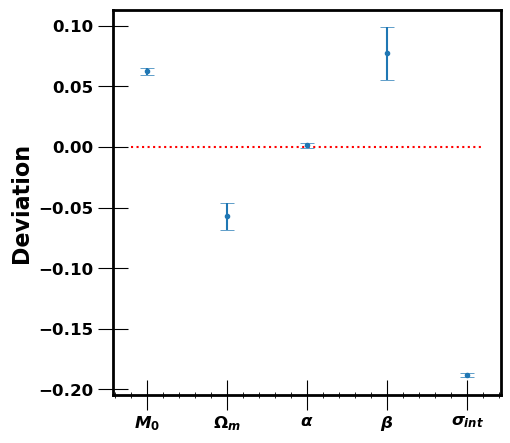

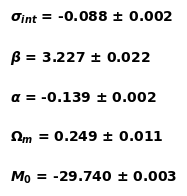

In [36]:
plot_edris_biais(edris_res['res'], x0, cov)

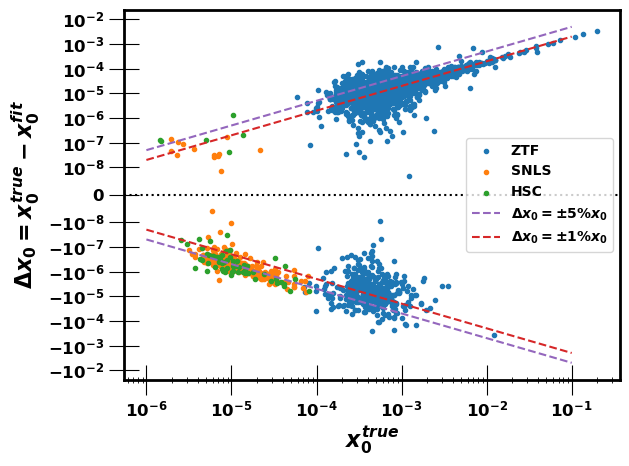

In [16]:
for s in nacl_fit.survey.unique():
    plt.scatter(nacl_fit[nacl_fit.survey==s].x0_init,
                nacl_fit[nacl_fit.survey==s].x0_init - nacl_fit[nacl_fit.survey==s].x0,
                marker='.', color=survey_colors[s], label=s)
plt.axhline(0, linestyle=':', color='k')
plt.plot([1e-6, 1e-1], 0.05*np.array([1e-6, 1e-1]), linestyle='--', color='tab:purple', label=r"$\Delta x_0 = \pm 5\% x_0$")
plt.plot([1e-6, 1e-1], -0.05*np.array([1e-6, 1e-1]), linestyle='--', color='tab:purple')
plt.plot([1e-6, 1e-1], 0.02*np.array([1e-6, 1e-1]), linestyle='--', color='tab:red', label=r"$\Delta x_0 = \pm 1\% x_0$")
plt.plot([1e-6, 1e-1], -0.02*np.array([1e-6, 1e-1]), linestyle='--', color='tab:red')
plt.yscale('symlog', linthresh=1e-8)
plt.xscale('log')
plt.xlabel(r'$x_0^{true}$')
plt.legend()
plt.ylabel(r'$\Delta x_0 = x_0^{true} - x_0^{fit}$')
plt.savefig('/cfs/data/angi0819/Projet_LPNHE/figures/nacl_lcfit/x0.png')

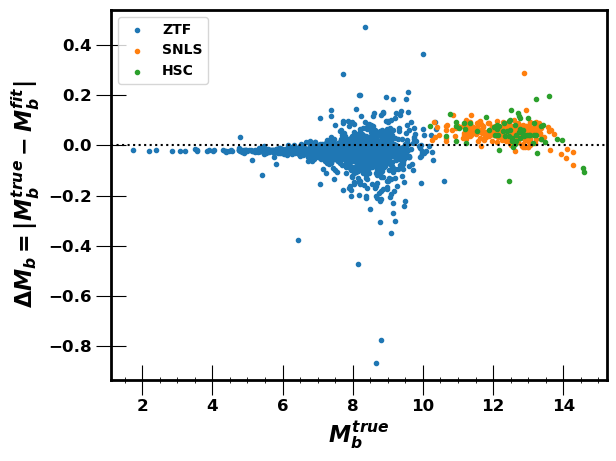

In [17]:
for s in nacl_fit.survey.unique():
    plt.scatter(-2.5*np.log10(nacl_fit[nacl_fit.survey==s].x0_init),
                -2.5*np.log10(nacl_fit[nacl_fit.survey==s].x0_init) - -2.5*np.log10(nacl_fit[nacl_fit.survey==s].x0),
                marker='.', color=survey_colors[s], label=s)
plt.axhline(0, linestyle=':', color='k')
plt.xlabel(r'$M_b^{true}$')
plt.legend()
plt.ylabel(r'$\Delta M_b = |M_b^{true} - M_b^{fit}|$')
plt.savefig('/cfs/data/angi0819/Projet_LPNHE/figures/nacl_lcfit/Mb.png')

Text(0, 0.5, '$\\Delta M_b = |M_b^{true} - M_b^{fit}|$')

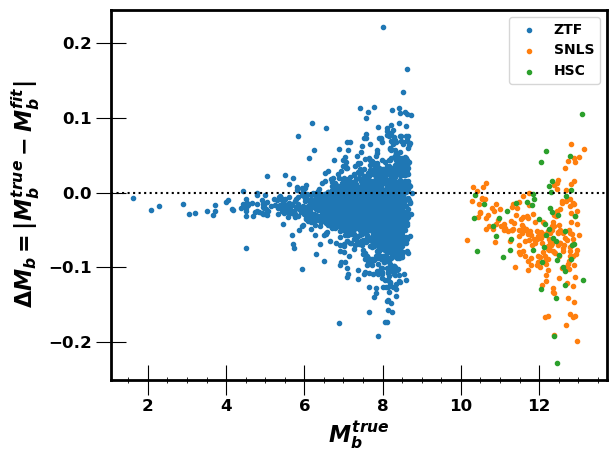

In [48]:
for s in nacl_fit.survey.unique():
    filt = (nacl_fit.survey==s) & nacl_fit.valid
    plt.scatter(nacl_fit[filt].mu_init,
                nacl_fit[filt].mu_init - nacl_fit[filt].mu,
                marker='.', color=survey_colors[s], label=s)
plt.axhline(0, linestyle=':', color='k')
plt.xlabel(r'$M_b^{true}$')
plt.legend()
plt.ylabel(r'$\Delta M_b = |M_b^{true} - M_b^{fit}|$')


In [50]:
(nacl_fit[nacl_fit.valid].mu_init - nacl_fit[nacl_fit.valid].mu).mean()

-0.025491375372567703

In [167]:
from edris.cosmo import Tcmb_to_Omega_gamma, mu
Tcmb = 2.7255
def flcdm(params, explanatory):
    p = {'Omega_m': params['Omega_m'],
         'Tcmb': Tcmb,
         'Omega_b_h2': 0.02204854,
         'Omega_k': 0.,
         'w': -1.,
         'H0': 68.1,
         'm_nu': 0.06,
         'Neff': 3.046
         }

    return mu(p, explanatory['z']) + params['M0']


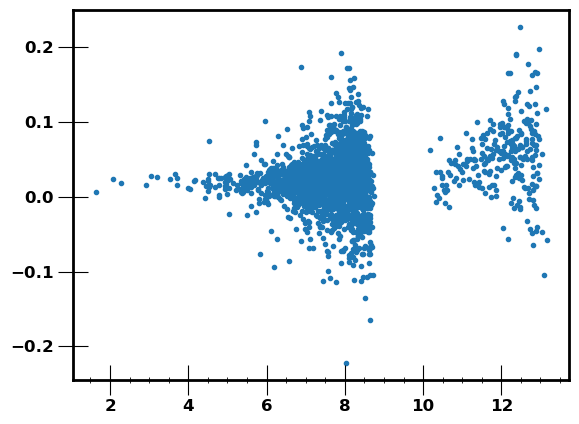

In [224]:
plt.scatter(nacl_fit[nacl_fit.valid].mu_init, nacl_fit[nacl_fit.valid].mu-nacl_fit[nacl_fit.valid].mu_init, marker='.')

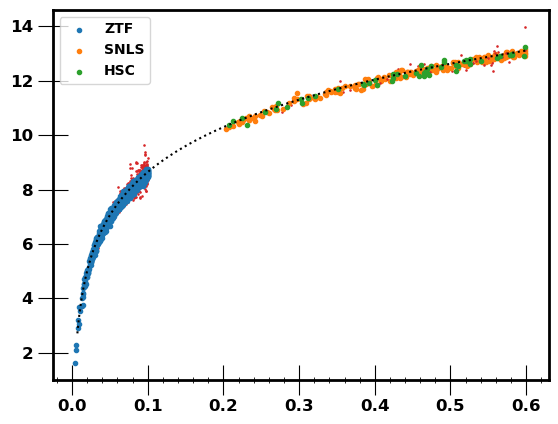

In [225]:
for s in nacl_fit.survey.unique():
    filt = (nacl_fit.survey==s) & (~nacl_fit.valid)
    plt.scatter(nacl_fit[filt].z, nacl_fit[filt].mu,
                s=3, color='tab:red', marker=".")
    filt = (nacl_fit.survey==s) & (nacl_fit.valid)
    plt.scatter(nacl_fit[filt].z, nacl_fit[filt].mu,
                color=survey_colors[s], marker=".", label=s)

z=jnp.linspace(7e-3, 0.6, 1000)
plt.plot(z, flcdm(edris_res['res'], {"z":z}), ':k')
# plt.plot(z, flcdm(x0, {"z":z}), ':r')
plt.legend()

In [226]:
use_vpec = nacl_fit[nacl_fit.valid & (nacl_fit.z > 7e-3) & (nacl_fit.survey=='ZTF')]

In [241]:
use_vpec['z_cosmo'] = data.loc[use_vpec.sn, "z_cosmo"]

2025-03-26 17:10:48 WARNING py.warnings - /tmp/ipykernel_20307/723749088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_vpec['z_cosmo'] = data.loc[use_vpec.sn, "z_cosmo"]



In [227]:
z=np.linspace(7e-3, 0.3, 10000)
mag_to_z = interp1d(
    flcdm(edris_res['res'], {"z":z}), z
)
z_cosmo_salt = mag_to_z(use_vpec.mu)

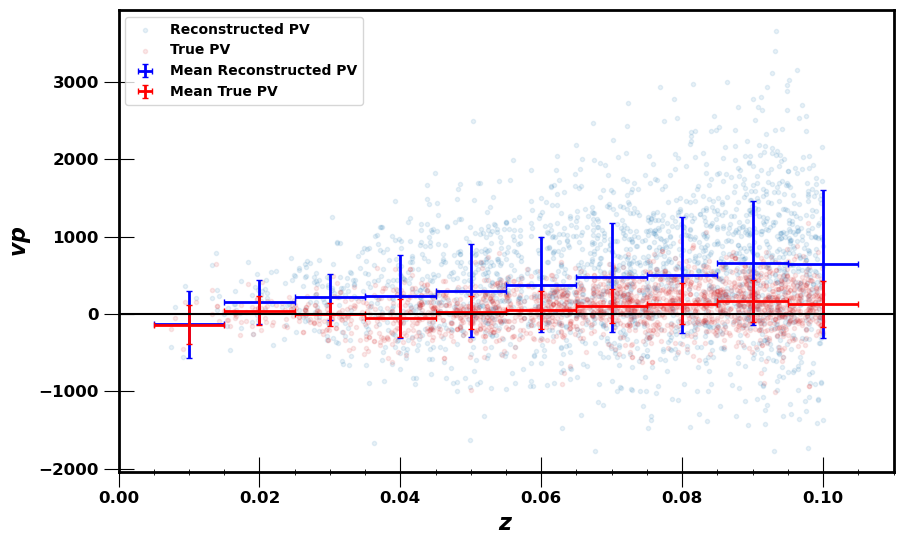

In [242]:
true_pv = (use_vpec.z - use_vpec.z_cosmo) * c * 1e-3 / (1 + use_vpec.z_cosmo)
edris_pv = (use_vpec.z - z_cosmo_salt) * c * 1e-3 / (1 + z_cosmo_salt)

z_max = 0.1
n_bins = 10
bounds = np.linspace(0.00, z_max, n_bins + 1)
width = z_max / n_bins
in_bins = [(use_vpec.z > z_min) & (use_vpec.z < z_min + width) for z_min in bounds]
plt.figure(figsize=(10, 6))

plt.scatter(use_vpec.z, edris_pv, marker=".", alpha=0.1, label="Reconstructed PV")
plt.scatter(use_vpec.z, true_pv, marker=".", color="tab:red", alpha=0.1, label="True PV")

plt.errorbar(
    bounds + width,
    [edris_pv[b_].mean() for b_ in in_bins],
    yerr=[edris_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="Mean Reconstructed PV",
)

plt.errorbar(
    bounds + width,
    [true_pv[b_].mean() for b_ in in_bins],
    yerr=[true_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    capsize=2,
    label="Mean True PV",
)

plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.axhline(0, color="k")

# EDRIS

Attention, Uchuu avec Planck15, Abacus avec Planck18

In [ ]:
from astropy.cosmology import Planck15, Planck18

# cosmo = Planck15

In [ ]:
from edris.cosmo import dL, Tcmb_to_Omega_gamma, Tcmb, mu

In [ ]:
def flcdm(params, explanatory):
    p = {
        "Omega_m": params["Omega_m"],
        "Omega_gamma": cosmo.Ogamma0,
        "w": -1.0,
        "H0": params["H0"],
        "Omega_k": cosmo.Ok0,
    }
    return mu(p, explanatory["z"]) - 19.3

In [ ]:
params = dict(
    H0=jnp.array([cosmo.H0.value]),
    Omega_m=jnp.array([cosmo.Om0]),
    Omega_gamma=jnp.array([cosmo.Ogamma0]),
    Omega_k=jnp.array([cosmo.Ok0]),
    w=jnp.array([-1.0]),
    coef=jnp.array([-0.14, 3.15]),
    sigma_int=jnp.array([jnp.array([0.1])]),
)

In [ ]:
source = sncosmo.get_source("salt2", version="2.4")
model = sncosmo.Model(
    source=source,
    effects=[sncosmo.CCM89Dust()],
    effect_names=["mw"],
    effect_frames=["obs"],
)

In [ ]:
with open("outdir/ztf_2M++_snls_hsc.pkl", "rb") as file:
    values = pickle.load(file)
    covs = pickle.load(file)

In [ ]:
values = values[values.valid].copy()
data_ztf,_ = load_from_skysurvey('./data/dataset_2M++.pkl', survey='ZTF')
data_hsc,_ = load_from_skysurvey('./data/dataset_hsc.pkl', survey='HSC')
data_snls,_ = load_from_skysurvey('./data/dataset_snls.pkl', survey='SNLS')
data=pandas.concat([data_ztf, data_hsc, data_snls])
values = values.join(data[['ra','dec']])
values.ra = (values.ra/180-1)*np.pi
values.dec = values.dec/180*np.pi
values["rcom"] = cosmo.comoving_distance(values.z).value

In [ ]:
from scipy.linalg import block_diag

full_matrix = block_diag(*[covs[i] for i in values.index])
n = len(values)
full_cov_sorted = full_matrix[
    :,
    [
        *[3 * i for i in range(n)],
        *[3 * i + 1 for i in range(n)],
        *[3 * i + 2 for i in range(n)],
    ],
][
    [
        *[3 * i for i in range(n)],
        *[3 * i + 1 for i in range(n)],
        *[3 * i + 2 for i in range(n)],
    ],
    :,
]

In [ ]:
from matplotlib.colors import SymLogNorm

plt.imshow(
    jnp.diag(1 / jnp.sqrt(jnp.diag(full_cov_sorted)))
    @ full_cov_sorted
    @ jnp.diag(1 / jnp.sqrt(jnp.diag(full_cov_sorted))),
    norm=SymLogNorm(vmin=-1, vmax=1, linthresh=1e-6),
)
plt.colorbar()

In [ ]:
values["survey"] = values.index.map(lambda s: s.split("_")[0])

In [ ]:
k, p = np.loadtxt('./data/power_spectrum.txt')

from flip import covariance, utils
coordinates = np.array([values['ra'],
                        values['dec'],
                        values['rcom']])
sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[k, p * utils.Du(k, sigmau_fiducial) ** 2]]}

size_batch=10_000
number_worker=64

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates,
    size_batch=size_batch,
    number_worker=number_worker,
)

covariance_fit.compute_full_matrix()
vpec_cov = (5/(c.value*1e-3*np.log(10)))**2*covariance_fit.covariance_dict['vv'][0] * \
            (np.array([1/values.z.values]).T @ \
             np.array([1/values.z.values]))
from matplotlib.colors import SymLogNorm
plt.figure(figsize=(7,7))
plt.imshow(vpec_cov, norm=SymLogNorm(linthresh=1e-7))
plt.colorbar(label=r'$mag^2$')
plt.title(r"$Cov_{mm}$")

In [ ]:
filt = (
    (values.c < 0.3) # & (values.err_x1 + np.abs(values.x1) < 5) & (values.err_c < 0.05)
)  # &\
# ((values.survey != 'ZTF') | (values.z < 0.1))
sum(filt)

In [ ]:
surveys = set(values[filt]["survey"])
survey_map = dict(zip(surveys, range(len(surveys))))
survey_id = jnp.array([survey_map[s] for s in values[filt]["survey"]])

In [ ]:
obs = Obs(
    mag=jnp.array(values[filt].magobs),
    variables=jnp.hstack([jnp.array(values[filt].x1), jnp.array(values[filt].c)]),
)

In [ ]:
exp = dict(
    z=jnp.array(values[filt].z),
    survey_id=survey_id,
    survey_map=survey_map,
)

In [ ]:
n = len(values)

In [ ]:
cov = FullCovariance(
    full_cov_sorted[:n, :n] + vpec_cov, full_cov_sorted[n:, n:], full_cov_sorted[:n, n:]
)

In [ ]:
cov = cov.select(filt.values)

In [ ]:
exp["map_survey"] = {
    v: k for v, k in zip(exp["survey_map"].values(), exp["survey_map"].keys())
}

In [ ]:
x0 = dict(
    H0=jnp.array([cosmo.H0.value]),
    Omega_m=jnp.array([cosmo.Om0]),
    coef=jnp.array([-0.14, 3.15]),
    variables=jnp.array(obs.variables.reshape((2, -1))),
    sigma_int=jnp.array([0.1]),
)

In [ ]:
for survey in exp["survey_map"].keys():
    plt.scatter(
        exp["z"][exp["survey_id"] == exp["survey_map"][survey]],
        obs.mag[
            exp["survey_id"] == exp["survey_map"][survey]
        ],  # - jnp.matmul(x0["coef"], obs.variables.reshape(2,-1)),
        c=survey_colors[survey],
        marker=".",
        label=survey,
    )

plt.plot(
    np.linspace(1e-3, 1, 1000),
    flcdm(params, {"z": jnp.linspace(5e-3, 1, 1000)}),
    linestyle=":",
    color="k",
    label="Planck 2015",
)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.legend()

In [ ]:
for survey in exp["survey_map"].keys():
    plt.scatter(
        exp["z"][exp["survey_id"] == exp["survey_map"][survey]],
        obs.mag[exp["survey_id"] == exp["survey_map"][survey]]
        - flcdm(params, {"z": exp["z"][exp["survey_id"] == exp["survey_map"][survey]]}),
        # - jnp.matmul(x0["coef"], obs.variables.reshape(2,-1)),
        c=survey_colors[survey],
        marker=".",
        label=survey,
    )

plt.axhline(0, linestyle=":", color="k", label="Planck 15")
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.legend()

In [ ]:
fig, (ax_mm, ax_mx, ax_xx) = plt.subplots(ncols = 3, figsize=(15,4))
im_mm = ax_mm.imshow(jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_mm))) @ cov.C_mm @ jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_mm))), norm=SymLogNorm(linthresh=1e-3), cmap="RdBu")
plt.colorbar(im_mm, ax=ax_mm)
im_mx = ax_mx.imshow(jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_mm))) @ cov.C_mx @ jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_xx))), norm=SymLogNorm(linthresh=1e-3), cmap="RdBu")
plt.colorbar(im_mx, ax=ax_mx)
im_xx = ax_xx.imshow(jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_xx))) @ cov.C_xx @ jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_xx))), norm=SymLogNorm(linthresh=1e-3), cmap="RdBu")
plt.colorbar(im_xx, ax=ax_xx)


In [ ]:
L = lambda x: likelihood(
    x, exp, cov, obs, cosmo=flcdm, truncated=False, restricted=False
)

In [ ]:
L(x0)

In [ ]:
fit_params = dict(niter=1000, lmbda=1e4, tol=1e-3, max_iter_tncg=None, verbose=True)

In [ ]:
res, loss, lmbda, iter_params = tncg(L, x0, **fit_params)

In [ ]:
jax.tree.map(lambda x, y: x - y, res, x0)

In [ ]:
hess = jax.hessian(L)(res)

In [ ]:
n = {k1: hess[k1][k1].shape[1] for k1 in hess.keys()}
n["variables"] *= n["coef"]
flatten_hess = jnp.vstack(
    [
        np.hstack([hess[k1][k2].reshape(n[k1], n[k2]) for k2 in hess.keys()])
        for k1 in hess.keys()
    ]
)
cov_res = jnp.linalg.inv(0.5 * flatten_hess)

In [ ]:
with open("outdir/edris_2M++_snls_hsc.pkl", "wb") as file:
    pickle.dump(obs, file)
    pickle.dump(exp, file)
    pickle.dump(cov, file)
    pickle.dump(res, file)
    pickle.dump(cov_res, file)

In [ ]:
from matplotlib.colors import SymLogNorm

plt.imshow(cov_res, norm=SymLogNorm(linthresh=1e-6, vmin=-1, vmax=1), cmap="RdBu")
plt.colorbar()

In [ ]:
potential_keys = ["H0", "M0", "Omega_m", "Omega_r", "Omega_l", "coef", "sigma_int"]
latex_keys = {
    "H0": "$H_0$",
    "M0": "$M_0$",
    "Omega_m": "$\\Omega_m$",
    "Omega_r": "$\\Omega_r$",
    "Omega_l": "$\\Omega_l$",
    "coef": ["$\\alpha$", "$\\beta$"],
    "sigma_int": "$\\sigma_{int}$",
    "alpha": "$\\alpha$",
    "beta": "$\\beta$",
}

In [ ]:
plt.rc("axes", labelsize=20)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=12)  # legend fontsize

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
keys = np.array(list(res.keys()))[[p in potential_keys for p in res.keys()]]
_labels, _values, _diffs = [], [], []
for k in keys:
    _labels += latex_keys[k] if isinstance(latex_keys[k], list) else [latex_keys[k]]
    _values += list(res[k])
    _diffs += list(res[k] - x0[k])
n_pars = len(keys)
ax.hlines(0, -1, 5 * n_pars + 1, color="r", linestyle=":")
ax.set_xticks(5 * np.arange(n_pars + 1), _labels)
ax.set_ylabel("Deviation")
plt.errorbar(
    5 * np.arange(n_pars + 1),
    _diffs,
    yerr=jnp.sqrt(jnp.diag(cov_res)[: n_pars + 1]),
    linestyle="",
    marker=".",
    capsize=5,
    capthick=0.5,
)
# plt.savefig('../figures/Uchuu_final_params.png')
fig, ax = plt.subplots(figsize=(1, 1))
ax.axis("off")
for i, pos in enumerate(np.arange(n_pars + 1) * 0.4):
    fig.text(
        0,
        pos,
        _labels[i] + f" = {_values[i]:.3f} $\\pm$ {jnp.sqrt(jnp.diag(cov_res)[i]):.3f}",
    )

In [ ]:
def plot_hubble(obs, res, cov_res, cosmo, x0):
    std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])

    fig, (ax1, ax2) = plt.subplots(
        nrows=2, sharex="col", figsize=(7, 6), gridspec_kw={"height_ratios": [3, 1]}
    )
    ax1.set_xscale("log")
    ax1.scatter(
        exp["z"], std_mag, s=0.5, alpha=0.3, color="k", label="Standardised magnitudes"
    )
    ax1.plot(
        np.linspace(5e-3, 1.2, 1000),
        cosmo(x0, {"z": np.linspace(5e-3, 1.2, 1000)}),
        color="tab:green",
        linestyle=":",
        label="Underlying cosmo",
    )

    ax2.scatter(exp["z"], std_mag - cosmo(x0, exp), color="k", s=0.5, alpha=0.3)

    if "mu_bins" in res.keys():
        ax1.errorbar(
            exp["z_bins"],
            res["mu_bins"],
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
            label="edris",
        )
        ax2.errorbar(
            exp["z_bins"],
            res["mu_bins"] - cosmo(x0, {"z": exp["z_bins"]}),
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
        )
    else:
        ax1.plot(
            jnp.linspace(5e-3, 1.2, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 1.2, 1000)}),
            color="tab:blue",
            label="edris",
        )
        ax2.plot(
            jnp.linspace(5e-3, 1.2, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 1.2, 1000)})
            - cosmo(x0, {"z": jnp.linspace(5e-3, 1.2, 1000)}),
            color="tab:blue",
        )

    ax1.legend()
    ax1.set_ylabel(r"$\mu$")

    lims = ax2.get_xlim()
    ax2.hlines(0.0, xmin=lims[0], xmax=lims[1], color="tab:green", linestyle=":")
    ax2.set_xlim(*lims)
    ax2.set_ylabel(r"$\Delta\mu$")
    ax2.set_xlabel(r"$z$")

    fig.suptitle(r"Modèle fitté par Edris")

In [ ]:
plot_hubble(obs, res, cov_res, flcdm, x0)

In [ ]:
mag_to_z = interp1d(
    flcdm(res, {"z": np.linspace(2e-3, 0.3, 10000)}), np.linspace(2e-3, 0.3, 10000)
)
z_cosmo_salt = mag_to_z(
    obs.mag[exp["survey_id"] == exp["survey_map"]["ZTF"]]
    - jnp.matmul(res["coef"], res["variables"])[
        exp["survey_id"] == exp["survey_map"]["ZTF"]
    ]
)

In [ ]:
data_ztf = data[data.index.isin(values[(values.survey == "ZTF") & filt].index)]
true_pv = (data_ztf.z - data_ztf.z_cosmo) * c * 1e-3 / (1 + data_ztf.z_cosmo)
edris_pv = (data_ztf.z - z_cosmo_salt) * c * 1e-3 / (1 + z_cosmo_salt)

z_max = 0.1
n_bins = 10
bounds = np.linspace(0.00, z_max, n_bins + 1)
width = z_max / n_bins
in_bins = [(data_ztf.z > z_min) & (data_ztf.z < z_min + width) for z_min in bounds]
plt.figure(figsize=(10, 6))

plt.scatter(data_ztf.z, edris_pv, marker=".", alpha=0.1, label="Reconstructed PV")
plt.scatter(
    data_ztf.z, true_pv, marker=".", color="tab:red", alpha=0.1, label="True PV"
)

plt.errorbar(
    bounds + width,
    [edris_pv[b_].mean() for b_ in in_bins],
    yerr=[edris_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="Mean Reconstructed PV",
)

plt.errorbar(
    bounds + width,
    [true_pv[b_].mean() for b_ in in_bins],
    yerr=[true_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    capsize=2,
    label="Mean True PV",
)

plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.axhline(0, color="k")

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(
    data_ztf.z,
    true_pv - edris_pv,
    marker=".",
    linestyle="",
    alpha=0.3,
    label="$vp_{vraie} - vp_{edris}$",
)
plt.errorbar(
    bounds + width,
    [(true_pv - edris_pv)[b_].mean() for b_ in in_bins],
    yerr=[(true_pv - edris_pv)[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="PV residuals",
)
plt.xlabel("$z$")
plt.ylabel(r"$\Delta pv$")
plt.axhline(0, color="k")
plt.axhline((true_pv - edris_pv).values.mean(), color="r", linestyle=":", label="Mean")
plt.axhline(
    (true_pv - edris_pv).values.mean() + (true_pv - edris_pv).values.std(),
    color="r",
    linestyle="--",
    label="std",
)
plt.axhline(
    (true_pv - edris_pv).values.mean() - (true_pv - edris_pv).values.std(),
    color="r",
    linestyle="--",
)

plt.legend()

In [ ]:
(true_pv - edris_pv).values.mean(), (true_pv - edris_pv).values.std()

# Power spectrum stuff

In [ ]:
from cosmoprimo import *
cosmo_p = Cosmology(engine='camb')
cosmo_planck = fiducial.Planck2018FullFlatLCDM()

In [ ]:
fo = Fourier(cosmo_p, engine='class')
pk = fo.pk_interpolator()
k = np.logspace(-6, 2, 1000)
z = 0
plt.loglog(k, pk(k, z=z), label='class')
fo_camb = cosmo_p.get_fourier(engine='camb') # second initialisation style
pk = fo_camb.pk_interpolator() # same number of cells are output than in CLASS
plt.loglog(k, pk(k, z=z), label='camb')
# cross density-velocity CDM + baryon power spectrum
plt.loglog(k,fo.pk_interpolator(of=('theta_cb', 'theta_cb'))(k, z=z), label=r'$P_{\delta_{cb}\theta_{cb}}$')
plt.loglog(k,fo.pk_interpolator(of=('theta_m', 'theta_m'))(k, z=z), label=r'$P_{\theta_{m}\theta_{m}}$')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend()
plt.show()

In [ ]:
k, p = np.loadtxt('test')

In [ ]:
with open("./outdir/ztf_2M++_snls_hsc_DR2cuts.pkl", "rb") as file:
    values=pickle.load(file)
    covs=pickle.load(file)

In [ ]:
data_ztf,_ = load_from_skysurvey('./data/dataset_2M++.pkl', survey='ZTF')
data_hsc,_ = load_from_skysurvey('./data/dataset_hsc.pkl', survey='HSC')
data_snls,_ = load_from_skysurvey('./data/dataset_snls.pkl', survey='SNLS')
data=pandas.concat([data_ztf, data_hsc, data_snls])

In [ ]:
values = values.join(data[['ra','dec']])
values.ra = (values.ra/180-1)*np.pi
values.dec = values.dec/180*np.pi

In [ ]:
values["rcom"] = cosmo.comoving_distance(values.z).value
values.sort_values('z', inplace=True)

In [ ]:
from flip import covariance, utils
coordinates = np.array([values['ra'],
                        values['dec'],
                        values['rcom']])
sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[k, p * utils.Du(k, sigmau_fiducial) ** 2]]}

size_batch=10_000
number_worker=64

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates,
    size_batch=size_batch,
    number_worker=number_worker,
)


In [ ]:
covariance_fit.compute_full_matrix()

In [ ]:
vpec_cov = (5/(c.value*1e-3*np.log(10)))**2*covariance_fit.covariance_dict['vv'][0] * \
            (np.array([1/values.z.values]).T @ \
             np.array([1/values.z.values]))

In [ ]:
from matplotlib.colors import SymLogNorm
fig, (ax_vv, ax_mm) = plt.subplots(figsize=(12,5), ncols=2)
im_vv = ax_vv.imshow(covariance_fit.covariance_dict['vv'][0], norm=SymLogNorm(linthresh=1e3))
plt.colorbar(im_vv, ax=ax_vv, label=r'$(km/s)^2$')
ax_vv.set_title(r'$Cov_{vv}$')
im_mm = ax_mm.imshow(vpec_cov, norm=SymLogNorm(linthresh=1e-7))
plt.colorbar(im_mm, ax=ax_mm, label=r'$mag^2$')
ax_mm.set_title(r"$Cov_{mm}$")

In [ ]:
plt.scatter(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]],
            true_pv[filt] - edris_vp,
            marker=".",
            linestyle='',
            alpha=0.3,
            label="$vp_{vraie} - vp_{edris}$")
mean_delta = [(true_pv[filt] - edris_vp).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_min) & \
                                         (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_min + 0.01)].mean()
              for z_min in np.linspace(0.00, 0.05, 6)]
err_delta = [(true_pv[filt] - edris_vp).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_min) & \
                                        (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_min + 0.01)].std()
             for z_min in np.linspace(0.00, 0.05, 6)]
plt.errorbar(np.linspace(0.00, 0.05, 6)+0.005,
             mean_delta,
             yerr=err_delta,
             xerr=0.005,
             linestyle='',
             color='tab:red',
             linewidth=2,
             capsize=2,
             label="Moyenne")

plt.xlabel("$z$")
plt.ylabel("$\Delta vp$")
plt.legend()
plt.ylim(-4000,4000)
plt.axhline(0, color='k')

In [ ]:
(true_pv[filt] - edris_vp).values.mean()